# ECG Classification

Verify usage of GPU. If Num GPUs Available is 0, consider enabling at least one. Otherwise, the models take too long to fit. 

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Import modules.

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Python waveform-database (WFDB) package
import wfdb

# Visualization
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score

# Tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPool1D, MaxPool2D
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.layers import concatenate, add, Add
from tensorflow.keras.layers import Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1 


# # PyTorch
# from torch import nn
# #!pip install torchsummary
# from torchsummary import summary

# Other
import os
import random
from loess.loess_1d import loess_1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.signal
import pickle
import itertools

# User defined
import scripts.ecg as ecg

# Downloaded scripts
from scripts.antonior92 import get_model

# Allow user defined modules to be dinamically updated
%load_ext autoreload
%autoreload 2

## Preparations for the Model

We will make some preparations in order to select the data, labels, and general configurations for the given exercise.

### Select Configuration

We will be running this notebook for several different combinations, like using raw data, data after one median filter pass, data without outliers, etc. To generalize it as much as possible and work with only one file, we will define a set of rules to get the desired dataset and to save the models in a more ordered way.

In [3]:
### Determine the transformed dataset to work with,
### where og = original, mf = after a median filter,
### bp = after a bandpass filter
# Available options:
# 'og', 'mf_200', 'og_bp_3_65', 'mf_200_bp_3_65'
data = 'mf_200'

### Determine whether to include outliers or not, 
### and if so, select the rules to determine them
# Available options:
# 'no', '5_25'
remove_outliers = 'no'

### Determine the DB to use
# Available options:
# 'PTB-XL'
current_db = 'PTB-XL'

### Determine how many observations per signal to use,
### using all (1.0) is very computationally expensive
# Available options:
# float in [0.1, 1.0]
cut = 0.5

### Determine which set of labels to use, where
### mi = MI vs OTHER, snomed = SNOMED CT Codes, etc.
# Available options:
# 'mi'
labels_id = 'mi'

With the configuration selected, define the paths that will be used.

In [4]:
### Dictionary to read the correct files:
path_dict = {
            'og'              :  f'{current_db}/',
            'mf_200'          :  f'{current_db}_mf=200/',
            'og_bp_3_65'      :  f'{current_db}_bp=[3,65]/',
            'mf_200_bp_3_65'  :  f'{current_db}_mf=200_bp=[3,65]/',   
            }

### Set the path to the data
path_ = f'data/{path_dict[data]}'

### Get index to remove outliers if desiered
if remove_outliers != 'no':
    first_rule = int(remove_outliers.split('_')[0])
    second_rule = int(remove_outliers.split('_')[1])
    inliers_idx = ecg.get_inliers(path_, first_rule, second_rule)
    
### Set the path to the model
models_path = path_ + labels_id + f'/{data}_ct_{str(cut)}/'
if remove_outliers != 'no':   
    models_path = models_path[:-1] + f'_ol_{remove_outliers}/'
models_path = models_path.replace('data', 'models')

### Create the path to the model
ecg.make_dir(models_path)

# Set the path to the results
results_path = models_path.replace('models', 'results')

### Create the path to the results
ecg.make_dir(results_path)

### Define the loss function depending on the label
loss_function = ecg.loss_function_dict[labels_id]

### Define the metrics to track depending on the label
metrics_to_track = ecg.metrics_to_track_dict[labels_id]

### Get Data

Select the database on which the model training will be performed and get the data.

In [5]:
# Determine the file names and load the data
X_name = 'X_1_21837.npy'
M_name = 'M.csv'
X, M = ecg.load_X_and_M(path_, X_name, M_name)

# Load the labels
Y = ecg.load_labels_train(path_, labels_id)

### Drop Outliers

If the parameter `remove_outliers` was different than `no`, then we drop the outliers based on the file that has the criteria to detect them.

In [6]:
if remove_outliers != 'no':

    # Filter out the outliers
    X = X[inliers_idx]    
    M = M.loc[inliers_idx]
    M = M.reset_index(drop=True)
    Y = Y.loc[inliers_idx]
    Y = Y.reset_index(drop=True)

### Cut the Signals

We  reduce the length of the signals since it would be too computationally costly otherwise at the moment. The computer we are currently working on can at most run around 2,500 observations pero signal. We are taking the first `cut` proportions of the register, since, as ECGs are sequential data, should not make this selection at random.

In [7]:
X_cut = X[:, :int(cut * X.shape[1]), :]

### Train, Validation & Test

Define the proportions for each set.

In [8]:
val_size = 0.2
test_size = 0.1

Define the indices so that we can recover them later

In [9]:
indices = np.arange(len(X_cut))

Retrieve the train, validation and test sets for:

    x : The signals
    y : The labels
    idx : The indices of the original X and Y
    age_n_sex : The age and sex

In [10]:
# Train and test
train_set_x, test_set_x       =  train_test_split(X_cut,   test_size=test_size, random_state=ecg.random_state)
train_set_y, test_set_y       =  train_test_split(Y,       test_size=test_size, random_state=ecg.random_state)
train_set_idx, test_set_idx   =  train_test_split(indices, test_size=test_size, random_state=ecg.random_state)

# Train and val
train_set_x, val_set_x        =  train_test_split(train_set_x,   test_size=val_size/(1-test_size), 
                                                 random_state=ecg.random_state)
train_set_y, val_set_y        =  train_test_split(train_set_y,   test_size=val_size/(1-test_size), 
                                                 random_state=ecg.random_state)
train_set_idx, val_set_idx    =  train_test_split(train_set_idx, test_size=val_size/(1-test_size), 
                                                 random_state=ecg.random_state)

# Get the age and sex given the indices
train_set_age_n_sex, mean_age =  ecg.age_and_sex_set(M, train_set_idx)
val_set_age_n_sex             =  ecg.age_and_sex_set(M, val_set_idx, mean_age)
test_set_age_n_sex            =  ecg.age_and_sex_set(M, test_set_idx, mean_age)

# Get number of batches
n_total_train =  train_set_x.shape[0]
batches       =  n_total_train // ecg.batch_size

# Convert everything to tensors
train_set_x   =  tf.convert_to_tensor(train_set_x)
val_set_x     =  tf.convert_to_tensor(val_set_x)
test_set_x    =  tf.convert_to_tensor(test_set_x)

train_set_y   =  tf.convert_to_tensor(train_set_y)
val_set_y     =  tf.convert_to_tensor(val_set_y)
test_set_y    =  tf.convert_to_tensor(test_set_y)

train_set_age_n_sex   =  tf.convert_to_tensor(train_set_age_n_sex)
val_set_age_n_sex     =  tf.convert_to_tensor(val_set_age_n_sex)
test_set_age_n_sex    =  tf.convert_to_tensor(test_set_age_n_sex)

We verify that we have a stratified distribution of labels inthe 3 sets.

In [11]:
# fig, axs = plt.subplots(1,3, figsize = (16,6))
# axs[0].bar(['MI', 'OTHER'], train_set_y.sum(0) /  train_set_y.sum(), )
# axs[1].bar(['MI', 'OTHER'], val_set_y.sum(0) /  val_set_y.sum())
# axs[2].bar(['MI', 'OTHER'], test_set_y.sum(0) /  test_set_y.sum())
# [ax.set_ylim(0,0.8) for ax in axs]

# axs[1].set_title('Distribution of labels on Train, Validation and Test sets', y = 1.04, fontsize=18);

## Model

We can now begin training models. We will make it very apparent when we add or change elements to the arquitecture, in order to quickly recognize them.

We set the universal parameters for the CNNs.

In [12]:
batch_size  =  64
img_h       =  X_cut.shape[1]
img_w       =  X_cut.shape[2]
d_model     =  256
optimizer   =  'adam'
epochs      =  100
patience    =  10

# =============================================================

#### Binary - Simplest model

# =============================================================

In general, we only use the ECG as input. However, in some models we add additional variables.

In [134]:
train_x = train_set_x
val_x = val_set_x
test_x = test_set_x

Define the model id. This must be different from any other since we are not overwritting.

In [135]:
model_id     =  '1'
model_path   =  models_path + model_id
result_path  =  results_path + model_id

Load the model if it has been created, else create a new instance of it.

In [136]:
try:
    os.listdir(model_path)
    model = tf.keras.models.load_model(model_path + '/model.h5')
    fitted_model = pd.read_csv(result_path + '/history.csv', index_col=0)
    found = True
    
except FileNotFoundError:
    ecg.make_dir(model_path)
    ecg.make_dir(result_path)    
    found = False

Define the architecture of the network.

In [137]:
if not found:
    
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(64, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Conv1D(128, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Conv1D(256, 3, activation='relu', strides=1, padding="same"),
            MaxPool1D(),

            Flatten(),
            Dense(128, activation='relu'),
            Dense(len(Y.columns), activation='sigmoid')
        ])
    
print('Number of parameters:')    
ecg.get_number_of_parameters(model, path = model_path)    

Number of parameters:
Total params:  10,349,505
Trainable params:  10,349,505
Non-trainable params:  0


Train the model.

In [138]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_to_track)

    # Train
    fitted_model = model.fit(train_x, train_set_y, steps_per_epoch=batches,
                             epochs=epochs, validation_data=(val_x, val_set_y),                                 
                             callbacks=[EarlyStopping(monitor='val_loss', patience=patience)])
    
    # Save
    model.save(model_path + '/model.h5')
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv(result_path + '/history.csv')

Epoch 1/100
229/229 [==============================] - 9s 37ms/step - loss: 0.5231 - accuracy: 0.7583 - val_loss: 0.4408 - val_accuracy: 0.7975
Epoch 2/100
229/229 [==============================] - 8s 35ms/step - loss: 0.4017 - accuracy: 0.8192 - val_loss: 0.3989 - val_accuracy: 0.8246
Epoch 3/100
229/229 [==============================] - 8s 35ms/step - loss: 0.3397 - accuracy: 0.8556 - val_loss: 0.4043 - val_accuracy: 0.8315
Epoch 4/100
229/229 [==============================] - 8s 35ms/step - loss: 0.3055 - accuracy: 0.8698 - val_loss: 0.3823 - val_accuracy: 0.8432
Epoch 5/100
229/229 [==============================] - 8s 35ms/step - loss: 0.2586 - accuracy: 0.8930 - val_loss: 0.4338 - val_accuracy: 0.8398
Epoch 6/100
229/229 [==============================] - 8s 35ms/step - loss: 0.2158 - accuracy: 0.9131 - val_loss: 0.4463 - val_accuracy: 0.8370
Epoch 7/100
229/229 [==============================] - 8s 36ms/step - loss: 0.1635 - accuracy: 0.9333 - val_loss: 0.5521 - val_accuracy:

Monitor the training and validation loss.

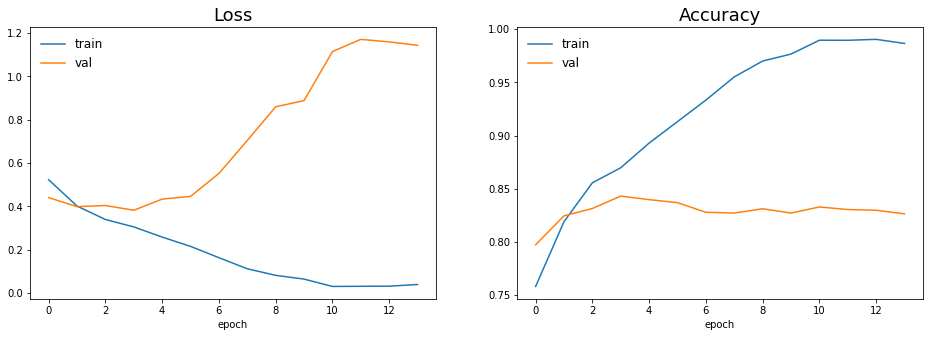

In [139]:
ecg.plot_model_history(fitted_model)

### Metrics

We calculate some metrics to further compare the models. We do all of this using the test set, since that would help us better represent how the models will perform in new data.

In the case of MI prediction, we will look at the results in 3 ways:
    
    1. Using a threshold of 0.5 to determine MI vs Other:
       This one is probably the least important, we only include it since a threshold
       of 0.5 is the most standard way to evaluate  classification problems
       
    2. Equalize recall and specificity:
       This approach has the goal to optimize both recall and specificity as much as possible.
       
    3. Optimize recall:
       We will define a target recall, 90% specifically, and visualize how the other metrics
       behave conditional on this.

In [140]:
# Set the threshold and target recall
threshold      =  0.5
target_recall  =  0.9

if not found:
    # Calculate the metrics given test predictions 
    test_pred, test_score    =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
    test_metrics             =  ecg.calculate_metrics_mi(test_set_y.numpy(), test_pred, test_score,
                                                         target_recall=target_recall)

    # Save the metrics
    with open(result_path + '/metrics.pickle', 'wb') as handle:
        pickle.dump(test_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    num_metrics = {key : values for key, values in test_metrics.items() if ecg.filter_metric(key)}
    pd.Series(num_metrics).to_csv(result_path + '/metrics.csv')

# Retrieve the metrics
with open(result_path + '/metrics.pickle', 'rb') as handle:
    test_metrics = pickle.load(handle)
    
# Obtain  fpr and tpr to plot the ROC curve
fpr, tpr, thresholds = test_metrics['roc_curve']
include_points = {'' : 'orange', 'equal_' : 'green', 'target_' : 'red',}

#### ROC Curve

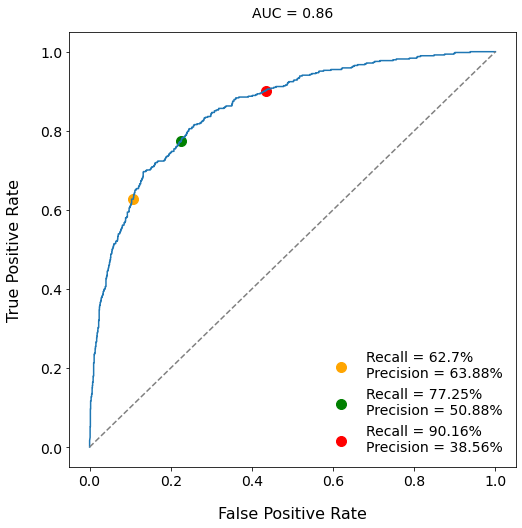

In [141]:
ecg.plot_roc_curve_mi(fpr, tpr, test_metrics, include_points)

**Threshold = 50%**

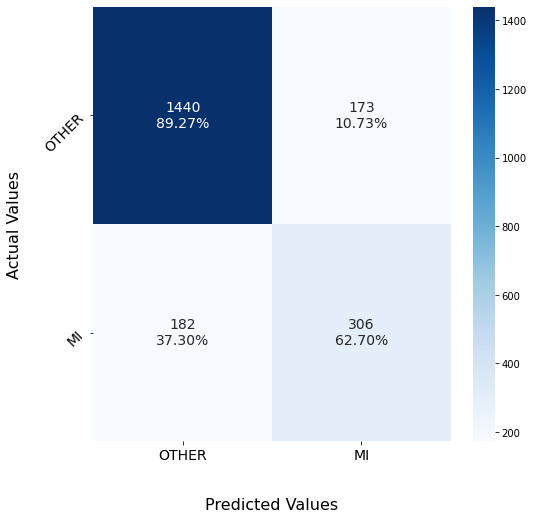

In [142]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['confusion_matrix'])

**Recall = Specificity**

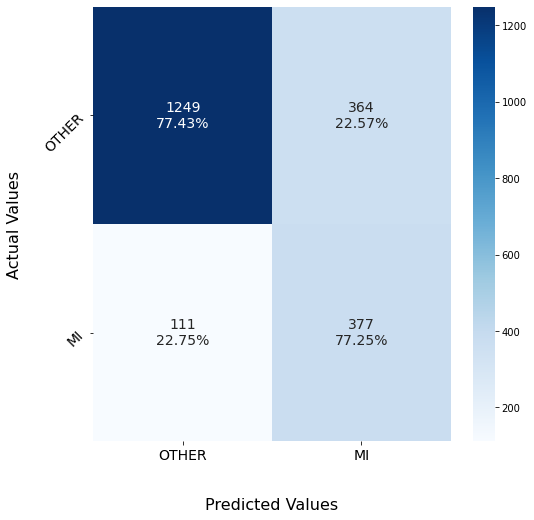

In [143]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['equal_confusion_matrix'])

**Recall = 90%**

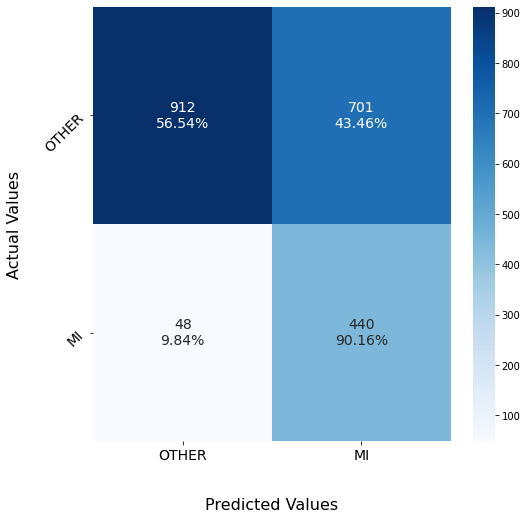

In [144]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['target_confusion_matrix'])

# =============================================================

#### Binary - Adding different Kernel and Stride Sizes

# =============================================================

In general, we only use the ECG as input. However, in some models we add additional variables.

In [146]:
train_x = train_set_x
val_x = val_set_x
test_x = test_set_x

Define the model id. This must be different from any other since we are not overwritting.

In [147]:
model_id     =  'ks_1'
model_path   =  models_path + model_id
result_path  =  results_path + model_id

Load the model if it has been created, else create a new instance of it.

In [148]:
try:
    os.listdir(model_path)
    model = tf.keras.models.load_model(model_path + '/model.h5')
    fitted_model = pd.read_csv(result_path + '/history.csv', index_col=0)
    found = True
    
except FileNotFoundError:
    ecg.make_dir(model_path)
    ecg.make_dir(result_path)    
    found = False

Define the architecture of the network.

In [149]:
if not found:
    
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same"),
            MaxPool1D(),

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(len(Y.columns), activation='sigmoid')
        ])
    
print('Number of parameters:')    
ecg.get_number_of_parameters(model, path = model_path)    

Number of parameters:
Total params:  2,250,881
Trainable params:  2,250,881
Non-trainable params:  0


Train the model.

In [150]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_to_track)

    # Train
    fitted_model = model.fit(train_x, train_set_y, steps_per_epoch=batches,
                             epochs=epochs, validation_data=(val_x, val_set_y),                                 
                             callbacks=[EarlyStopping(monitor='val_loss', patience=patience)])
    
    # Save
    model.save(model_path + '/model.h5')
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv(result_path + '/history.csv')

Epoch 1/100
229/229 [==============================] - 9s 33ms/step - loss: 0.4418 - accuracy: 0.8093 - val_loss: 0.3813 - val_accuracy: 0.8396
Epoch 2/100
229/229 [==============================] - 8s 33ms/step - loss: 0.3333 - accuracy: 0.8597 - val_loss: 0.3378 - val_accuracy: 0.8532
Epoch 3/100
229/229 [==============================] - 8s 37ms/step - loss: 0.2966 - accuracy: 0.8756 - val_loss: 0.3632 - val_accuracy: 0.8491
Epoch 4/100
229/229 [==============================] - 9s 38ms/step - loss: 0.2679 - accuracy: 0.8882 - val_loss: 0.3553 - val_accuracy: 0.8684
Epoch 5/100
229/229 [==============================] - 9s 39ms/step - loss: 0.2358 - accuracy: 0.9007 - val_loss: 0.3728 - val_accuracy: 0.8553
Epoch 6/100
229/229 [==============================] - 9s 38ms/step - loss: 0.2031 - accuracy: 0.9148 - val_loss: 0.4374 - val_accuracy: 0.8536
Epoch 7/100
229/229 [==============================] - 9s 38ms/step - loss: 0.1616 - accuracy: 0.9321 - val_loss: 0.6108 - val_accuracy:

Monitor the training and validation loss.

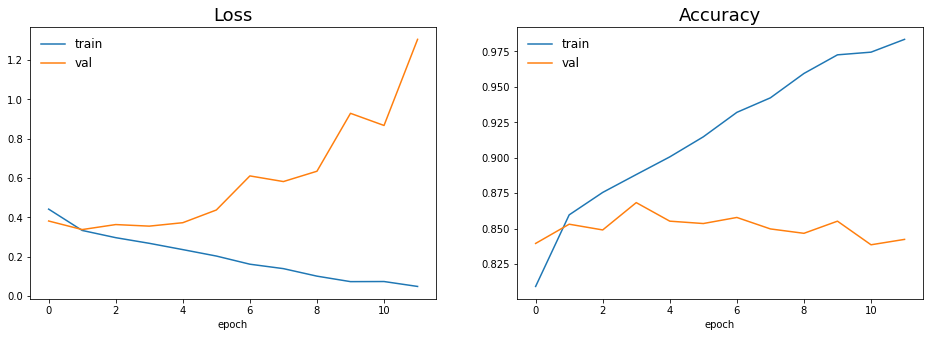

In [151]:
ecg.plot_model_history(fitted_model)

### Metrics

We calculate some metrics to further compare the models. We do all of this using the test set, since that would help us better represent how the models will perform in new data.

In the case of MI prediction, we will look at the results in 3 ways:
    
    1. Using a threshold of 0.5 to determine MI vs Other:
       This one is probably the least important, we only include it since a threshold
       of 0.5 is the most standard way to evaluate  classification problems
       
    2. Equalize recall and specificity:
       This approach has the goal to optimize both recall and specificity as much as possible.
       
    3. Optimize recall:
       We will define a target recall, 90% specifically, and visualize how the other metrics
       behave conditional on this.

In [152]:
# Set the threshold and target recall
threshold      =  0.5
target_recall  =  0.9

if not found:
    # Calculate the metrics given test predictions 
    test_pred, test_score    =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
    test_metrics             =  ecg.calculate_metrics_mi(test_set_y.numpy(), test_pred, test_score,
                                                         target_recall=target_recall)

    # Save the metrics
    with open(result_path + '/metrics.pickle', 'wb') as handle:
        pickle.dump(test_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    num_metrics = {key : values for key, values in test_metrics.items() if ecg.filter_metric(key)}
    pd.Series(num_metrics).to_csv(result_path + '/metrics.csv')

# Retrieve the metrics
with open(result_path + '/metrics.pickle', 'rb') as handle:
    test_metrics = pickle.load(handle)
    
# Obtain  fpr and tpr to plot the ROC curve
fpr, tpr, thresholds = test_metrics['roc_curve']
include_points = {'' : 'orange', 'equal_' : 'green', 'target_' : 'red',}

#### ROC Curve

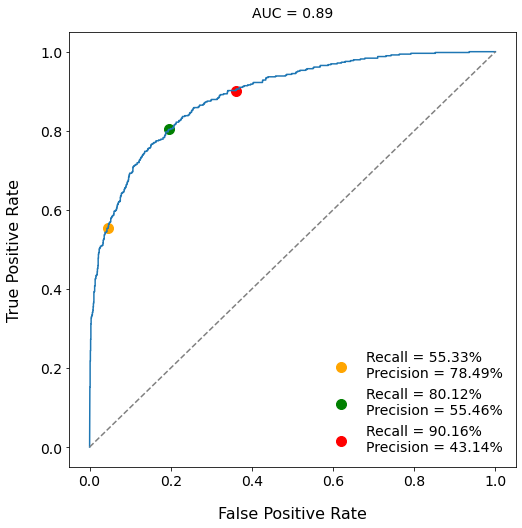

In [153]:
ecg.plot_roc_curve_mi(fpr, tpr, test_metrics, include_points)

**Threshold = 50%**

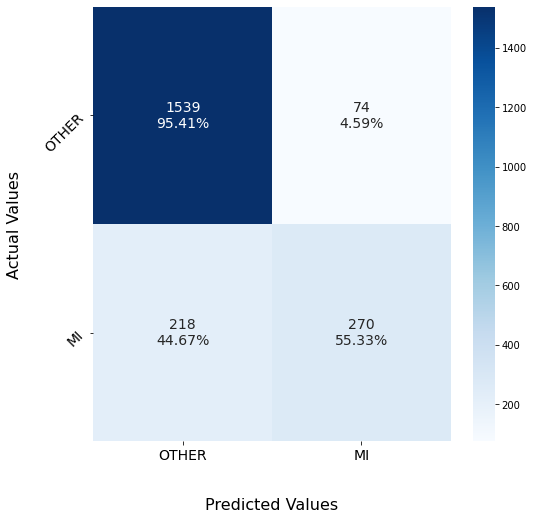

In [154]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['confusion_matrix'])

**Recall = Specificity**

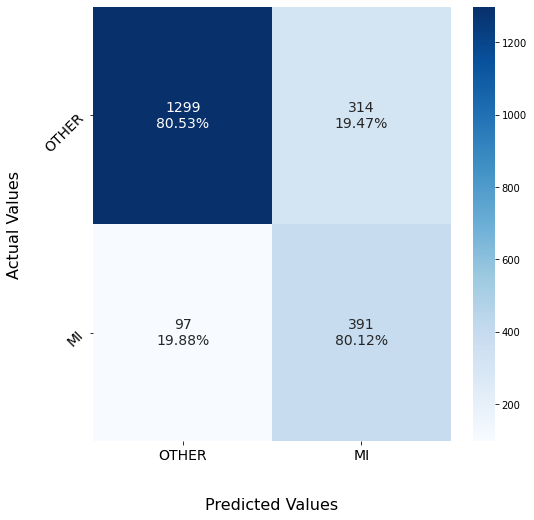

In [155]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['equal_confusion_matrix'])

**Recall = 90%**

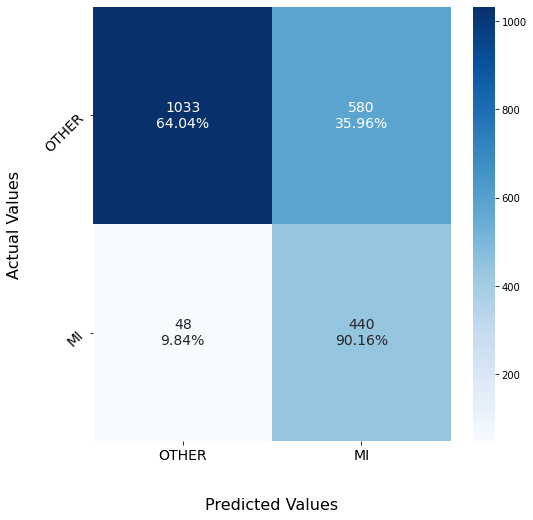

In [156]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['target_confusion_matrix'])

# =============================================================

#### Binary - Adding different Kernel and Stride Sizes + BatchNormalization

# =============================================================

In general, we only use the ECG as input. However, in some models we add additional variables.

In [157]:
train_x = train_set_x
val_x = val_set_x
test_x = test_set_x

Define the model id. This must be different from any other since we are not overwritting.

In [158]:
model_id     =  'ks_bn_1'
model_path   =  models_path + model_id
result_path  =  results_path + model_id

Load the model if it has been created, else create a new instance of it.

In [159]:
try:
    os.listdir(model_path)
    model = tf.keras.models.load_model(model_path + '/model.h5')
    fitted_model = pd.read_csv(result_path + '/history.csv', index_col=0)
    found = True
    
except FileNotFoundError:
    ecg.make_dir(model_path)
    ecg.make_dir(result_path)    
    found = False

Define the architecture of the network.

In [160]:
if not found:
    
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same", use_bias=False),
            BatchNormalization(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same", use_bias=False),
            BatchNormalization(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", use_bias=False),
            BatchNormalization(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", use_bias=False),
            BatchNormalization(),

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(len(Y.columns), activation='sigmoid')
        ])
    
print('Number of parameters:')    
ecg.get_number_of_parameters(model, path = model_path)    

Number of parameters:
Total params:  6,382,593
Trainable params:  6,380,801
Non-trainable params:  1,792


Train the model.

In [161]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_to_track)

    # Train
    fitted_model = model.fit(train_x, train_set_y, steps_per_epoch=batches,
                             epochs=epochs, validation_data=(val_x, val_set_y),                                 
                             callbacks=[EarlyStopping(monitor='val_loss', patience=patience)])
    
    # Save
    model.save(model_path + '/model.h5')
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv(result_path + '/history.csv')

Epoch 1/100
229/229 [==============================] - 22s 90ms/step - loss: 0.7743 - accuracy: 0.7613 - val_loss: 0.4622 - val_accuracy: 0.7951
Epoch 2/100
229/229 [==============================] - 20s 88ms/step - loss: 0.3736 - accuracy: 0.8366 - val_loss: 0.4123 - val_accuracy: 0.8251
Epoch 3/100
229/229 [==============================] - 20s 88ms/step - loss: 0.3220 - accuracy: 0.8589 - val_loss: 0.4263 - val_accuracy: 0.8315
Epoch 4/100
229/229 [==============================] - 20s 89ms/step - loss: 0.2759 - accuracy: 0.8781 - val_loss: 0.4754 - val_accuracy: 0.8408
Epoch 5/100
229/229 [==============================] - 20s 89ms/step - loss: 0.2301 - accuracy: 0.9023 - val_loss: 0.5341 - val_accuracy: 0.8215
Epoch 6/100
229/229 [==============================] - 20s 89ms/step - loss: 0.1925 - accuracy: 0.9215 - val_loss: 0.7331 - val_accuracy: 0.8367
Epoch 7/100
229/229 [==============================] - 20s 89ms/step - loss: 0.1407 - accuracy: 0.9457 - val_loss: 0.6882 - val_ac

Monitor the training and validation loss.

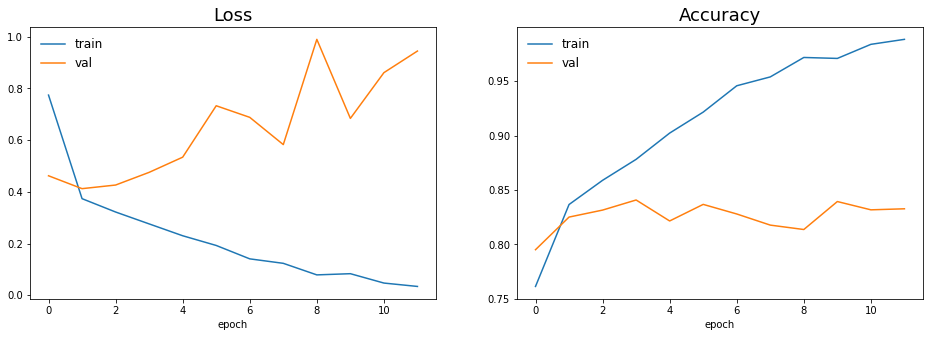

In [162]:
ecg.plot_model_history(fitted_model)

### Metrics

We calculate some metrics to further compare the models. We do all of this using the test set, since that would help us better represent how the models will perform in new data.

In the case of MI prediction, we will look at the results in 3 ways:
    
    1. Using a threshold of 0.5 to determine MI vs Other:
       This one is probably the least important, we only include it since a threshold
       of 0.5 is the most standard way to evaluate  classification problems
       
    2. Equalize recall and specificity:
       This approach has the goal to optimize both recall and specificity as much as possible.
       
    3. Optimize recall:
       We will define a target recall, 90% specifically, and visualize how the other metrics
       behave conditional on this.

In [163]:
# Set the threshold and target recall
threshold      =  0.5
target_recall  =  0.9

if not found:
    # Calculate the metrics given test predictions 
    test_pred, test_score    =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
    test_metrics             =  ecg.calculate_metrics_mi(test_set_y.numpy(), test_pred, test_score,
                                                         target_recall=target_recall)

    # Save the metrics
    with open(result_path + '/metrics.pickle', 'wb') as handle:
        pickle.dump(test_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    num_metrics = {key : values for key, values in test_metrics.items() if ecg.filter_metric(key)}
    pd.Series(num_metrics).to_csv(result_path + '/metrics.csv')

# Retrieve the metrics
with open(result_path + '/metrics.pickle', 'rb') as handle:
    test_metrics = pickle.load(handle)
    
# Obtain  fpr and tpr to plot the ROC curve
fpr, tpr, thresholds = test_metrics['roc_curve']
include_points = {'' : 'orange', 'equal_' : 'green', 'target_' : 'red',}

#### ROC Curve

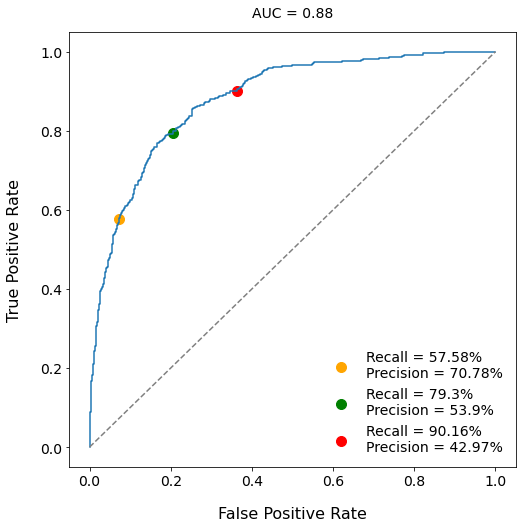

In [164]:
ecg.plot_roc_curve_mi(fpr, tpr, test_metrics, include_points)

**Threshold = 50%**

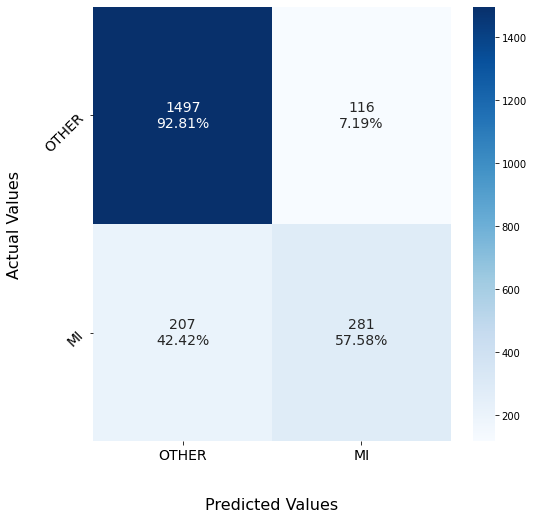

In [165]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['confusion_matrix'])

**Recall = Specificity**

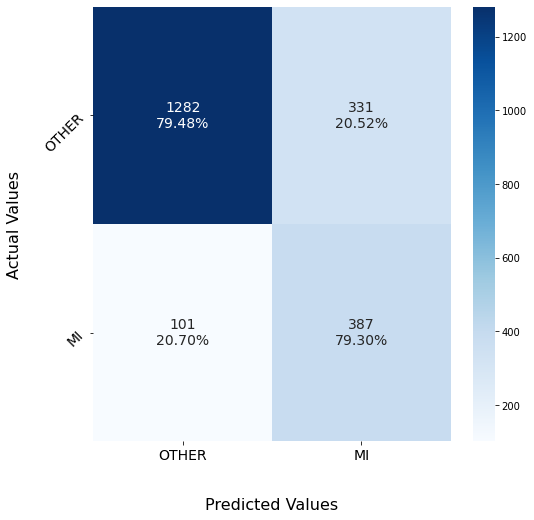

In [166]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['equal_confusion_matrix'])

**Recall = 90%**

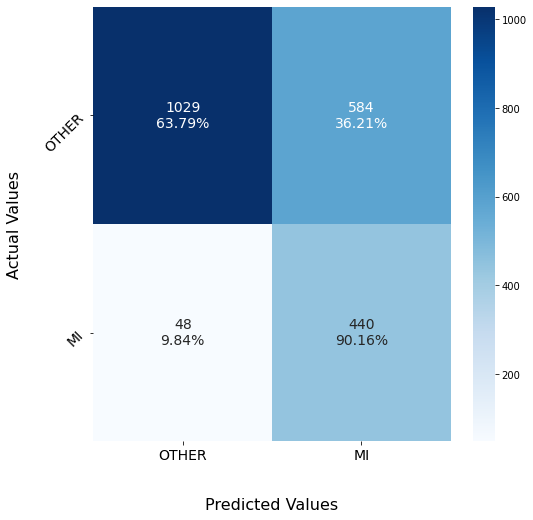

In [167]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['target_confusion_matrix'])

# =============================================================

#### Binary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer

# =============================================================

In general, we only use the ECG as input. However, in some models we add additional variables.

In [168]:
train_x = train_set_x
val_x = val_set_x
test_x = test_set_x

Define the model id. This must be different from any other since we are not overwritting.

In [169]:
model_id     =  'ks_bn_l1_1'
model_path   =  models_path + model_id
result_path  =  results_path + model_id

Load the model if it has been created, else create a new instance of it.

In [170]:
try:
    os.listdir(model_path)
    model = tf.keras.models.load_model(model_path + '/model.h5')
    fitted_model = pd.read_csv(result_path + '/history.csv', index_col=0)
    found = True
    
except FileNotFoundError:
    ecg.make_dir(model_path)
    ecg.make_dir(result_path)    
    found = False

Define the architecture of the network.

In [171]:
if not found:
    
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006)),
            MaxPool1D(),
            BatchNormalization(),            

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(len(Y.columns), activation='sigmoid')
        ])
    
print('Number of parameters:')    
ecg.get_number_of_parameters(model, path = model_path)    

Number of parameters:
Total params:  2,253,441
Trainable params:  2,252,161
Non-trainable params:  1,280


Train the model.

In [172]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_to_track)

    # Train
    fitted_model = model.fit(train_x, train_set_y, steps_per_epoch=batches,
                             epochs=epochs, validation_data=(val_x, val_set_y),                                 
                             callbacks=[EarlyStopping(monitor='val_loss', patience=patience)])
    
    # Save
    model.save(model_path + '/model.h5')
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv(result_path + '/history.csv')

Epoch 1/100
229/229 [==============================] - 12s 45ms/step - loss: 2.1134 - accuracy: 0.7380 - val_loss: 0.6705 - val_accuracy: 0.7382
Epoch 2/100
229/229 [==============================] - 10s 44ms/step - loss: 0.5016 - accuracy: 0.8051 - val_loss: 0.5904 - val_accuracy: 0.7744
Epoch 3/100
229/229 [==============================] - 10s 44ms/step - loss: 0.4486 - accuracy: 0.8227 - val_loss: 0.4667 - val_accuracy: 0.8172
Epoch 4/100
229/229 [==============================] - 10s 44ms/step - loss: 0.4340 - accuracy: 0.8330 - val_loss: 0.4309 - val_accuracy: 0.8379
Epoch 5/100
229/229 [==============================] - 10s 44ms/step - loss: 0.4118 - accuracy: 0.8431 - val_loss: 0.4188 - val_accuracy: 0.8372
Epoch 6/100
229/229 [==============================] - 10s 44ms/step - loss: 0.3826 - accuracy: 0.8531 - val_loss: 0.4358 - val_accuracy: 0.8341
Epoch 7/100
229/229 [==============================] - 10s 45ms/step - loss: 0.3760 - accuracy: 0.8537 - val_loss: 0.4065 - val_ac

Monitor the training and validation loss.

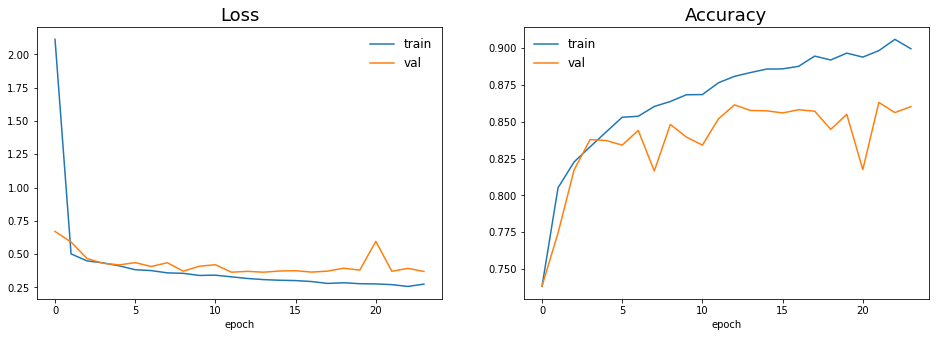

In [173]:
ecg.plot_model_history(fitted_model)

### Metrics

We calculate some metrics to further compare the models. We do all of this using the test set, since that would help us better represent how the models will perform in new data.

In the case of MI prediction, we will look at the results in 3 ways:
    
    1. Using a threshold of 0.5 to determine MI vs Other:
       This one is probably the least important, we only include it since a threshold
       of 0.5 is the most standard way to evaluate  classification problems
       
    2. Equalize recall and specificity:
       This approach has the goal to optimize both recall and specificity as much as possible.
       
    3. Optimize recall:
       We will define a target recall, 90% specifically, and visualize how the other metrics
       behave conditional on this.

In [174]:
# Set the threshold and target recall
threshold      =  0.5
target_recall  =  0.9

if not found:
    # Calculate the metrics given test predictions 
    test_pred, test_score    =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
    test_metrics             =  ecg.calculate_metrics_mi(test_set_y.numpy(), test_pred, test_score,
                                                         target_recall=target_recall)

    # Save the metrics
    with open(result_path + '/metrics.pickle', 'wb') as handle:
        pickle.dump(test_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    num_metrics = {key : values for key, values in test_metrics.items() if ecg.filter_metric(key)}
    pd.Series(num_metrics).to_csv(result_path + '/metrics.csv')

# Retrieve the metrics
with open(result_path + '/metrics.pickle', 'rb') as handle:
    test_metrics = pickle.load(handle)
    
# Obtain  fpr and tpr to plot the ROC curve
fpr, tpr, thresholds = test_metrics['roc_curve']
include_points = {'' : 'orange', 'equal_' : 'green', 'target_' : 'red',}

#### ROC Curve

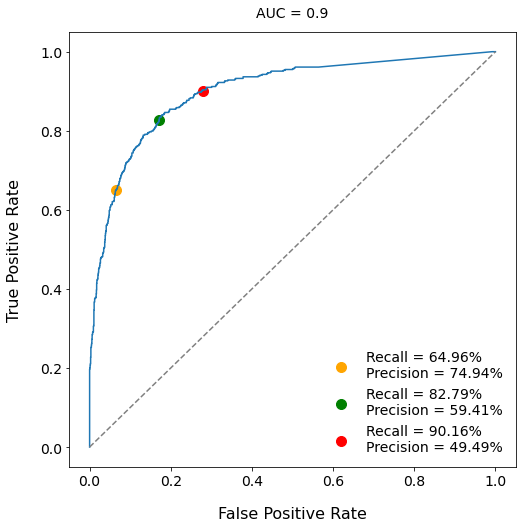

In [175]:
ecg.plot_roc_curve_mi(fpr, tpr, test_metrics, include_points)

**Threshold = 50%**

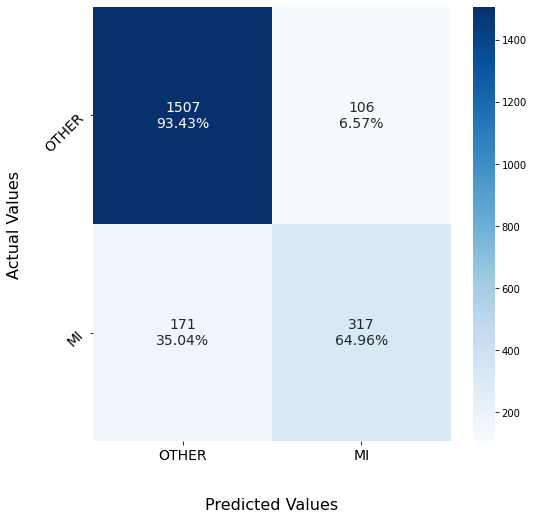

In [176]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['confusion_matrix'])

**Recall = Specificity**

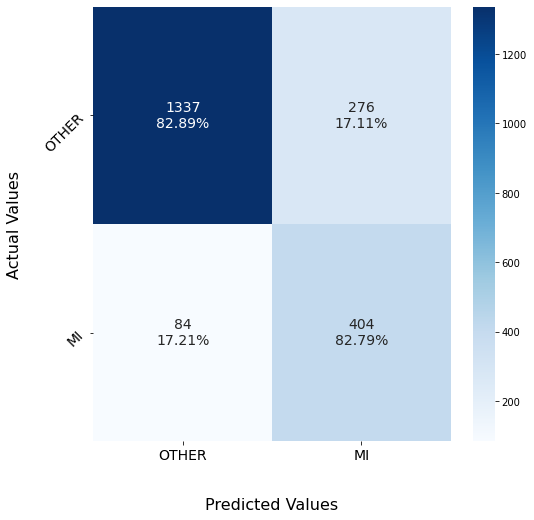

In [177]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['equal_confusion_matrix'])

**Recall = 90%**

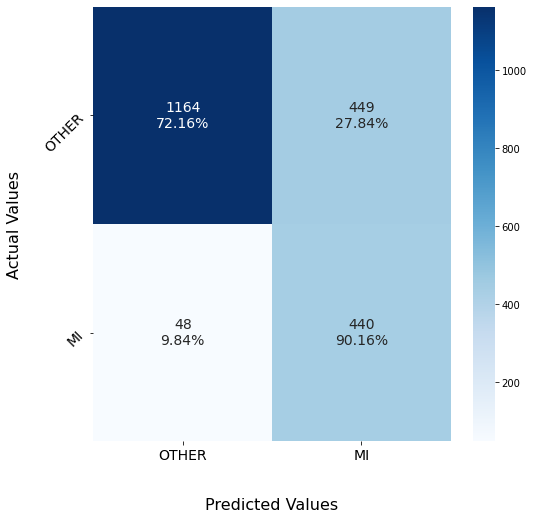

In [178]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['target_confusion_matrix'])

# =============================================================

#### Binary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Dropout

# =============================================================

In general, we only use the ECG as input. However, in some models we add additional variables.

In [179]:
train_x = train_set_x
val_x = val_set_x
test_x = test_set_x

Define the model id. This must be different from any other since we are not overwritting.

In [180]:
model_id     =  'ks_bn_l1_dr_1'
model_path   =  models_path + model_id
result_path  =  results_path + model_id

Load the model if it has been created, else create a new instance of it.

In [181]:
try:
    os.listdir(model_path)
    model = tf.keras.models.load_model(model_path + '/model.h5')
    fitted_model = pd.read_csv(result_path + '/history.csv', index_col=0)
    found = True
    
except FileNotFoundError:
    ecg.make_dir(model_path)
    ecg.make_dir(result_path)    
    found = False

Define the architecture of the network.

In [182]:
if not found:
    
    model = Sequential([
            InputLayer(input_shape=(img_h, img_w)),

            Conv1D(128, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),                 
            BatchNormalization(),
            Dropout(rate=0.3),

            Conv1D(256, 14, activation='relu', strides=3, padding="same"),
            MaxPool1D(),
            BatchNormalization(),
            Dropout(rate=0.3),
        
            Conv1D(d_model, 10, activation='relu', strides=2, padding="same"),
            MaxPool1D(),            
            BatchNormalization(),    
            Dropout(rate=0.3),

            Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006)),
            MaxPool1D(),            
            BatchNormalization(),            
            Dropout(rate=0.3),

            Flatten(),
            Dense(d_model, activation='relu'),
            Dense(len(Y.columns), activation='sigmoid')
        ])
    
print('Number of parameters:')    
ecg.get_number_of_parameters(model, path = model_path)    

Number of parameters:
Total params:  2,058,113
Trainable params:  2,056,321
Non-trainable params:  1,792


Train the model.

In [183]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_to_track)

    # Train
    fitted_model = model.fit(train_x, train_set_y, steps_per_epoch=batches,
                             epochs=epochs, validation_data=(val_x, val_set_y),                                 
                             callbacks=[EarlyStopping(monitor='val_loss', patience=patience)])
    
    # Save
    model.save(model_path + '/model.h5')
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv(result_path + '/history.csv')

Epoch 1/100
229/229 [==============================] - 31s 54ms/step - loss: 1.5684 - accuracy: 0.7514 - val_loss: 0.6640 - val_accuracy: 0.7413
Epoch 2/100
229/229 [==============================] - 11s 50ms/step - loss: 0.5123 - accuracy: 0.7940 - val_loss: 0.5201 - val_accuracy: 0.7846
Epoch 3/100
229/229 [==============================] - 11s 50ms/step - loss: 0.4651 - accuracy: 0.8111 - val_loss: 0.5218 - val_accuracy: 0.7934
Epoch 4/100
229/229 [==============================] - 12s 50ms/step - loss: 0.4334 - accuracy: 0.8235 - val_loss: 0.4495 - val_accuracy: 0.7937
Epoch 5/100
229/229 [==============================] - 12s 50ms/step - loss: 0.4175 - accuracy: 0.8290 - val_loss: 0.4141 - val_accuracy: 0.8229
Epoch 6/100
229/229 [==============================] - 12s 51ms/step - loss: 0.4020 - accuracy: 0.8365 - val_loss: 0.3895 - val_accuracy: 0.8348
Epoch 7/100
229/229 [==============================] - 12s 51ms/step - loss: 0.3868 - accuracy: 0.8463 - val_loss: 0.4882 - val_ac

Monitor the training and validation loss.

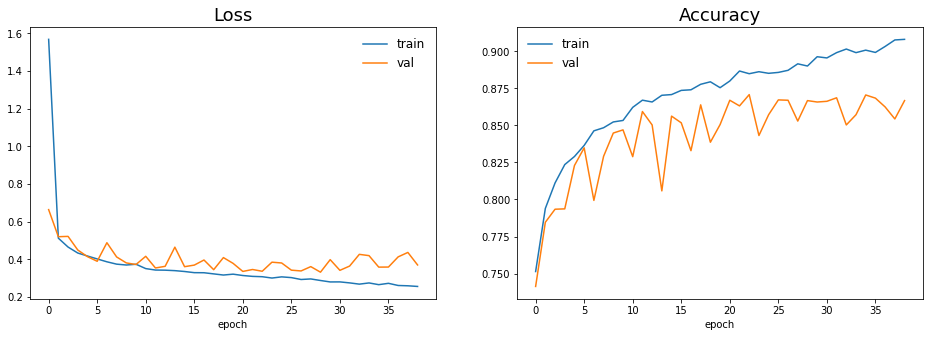

In [184]:
ecg.plot_model_history(fitted_model)

### Metrics

We calculate some metrics to further compare the models. We do all of this using the test set, since that would help us better represent how the models will perform in new data.

In the case of MI prediction, we will look at the results in 3 ways:
    
    1. Using a threshold of 0.5 to determine MI vs Other:
       This one is probably the least important, we only include it since a threshold
       of 0.5 is the most standard way to evaluate  classification problems
       
    2. Equalize recall and specificity:
       This approach has the goal to optimize both recall and specificity as much as possible.
       
    3. Optimize recall:
       We will define a target recall, 90% specifically, and visualize how the other metrics
       behave conditional on this.

In [185]:
# Set the threshold and target recall
threshold      =  0.5
target_recall  =  0.9

if not found:
    # Calculate the metrics given test predictions 
    test_pred, test_score    =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
    test_metrics             =  ecg.calculate_metrics_mi(test_set_y.numpy(), test_pred, test_score,
                                                         target_recall=target_recall)

    # Save the metrics
    with open(result_path + '/metrics.pickle', 'wb') as handle:
        pickle.dump(test_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    num_metrics = {key : values for key, values in test_metrics.items() if ecg.filter_metric(key)}
    pd.Series(num_metrics).to_csv(result_path + '/metrics.csv')

# Retrieve the metrics
with open(result_path + '/metrics.pickle', 'rb') as handle:
    test_metrics = pickle.load(handle)
    
# Obtain  fpr and tpr to plot the ROC curve
fpr, tpr, thresholds = test_metrics['roc_curve']
include_points = {'' : 'orange', 'equal_' : 'green', 'target_' : 'red',}

#### ROC Curve

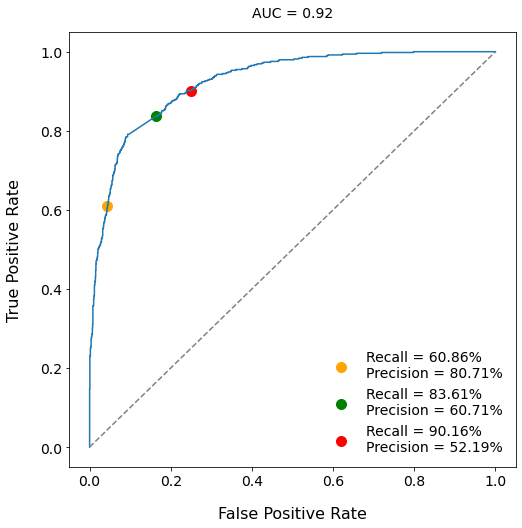

In [186]:
ecg.plot_roc_curve_mi(fpr, tpr, test_metrics, include_points)

**Threshold = 50%**

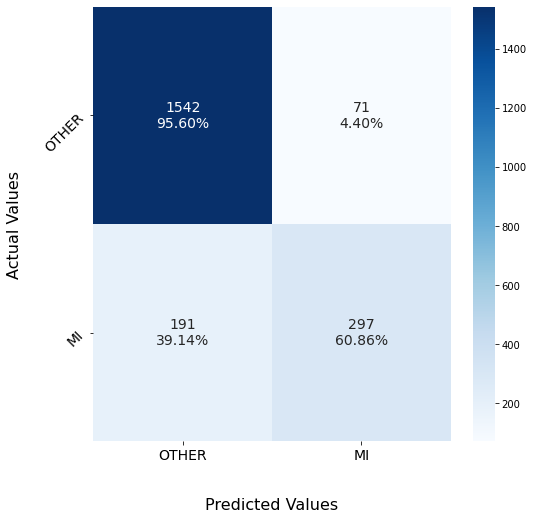

In [187]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['confusion_matrix'])

**Recall = Specificity**

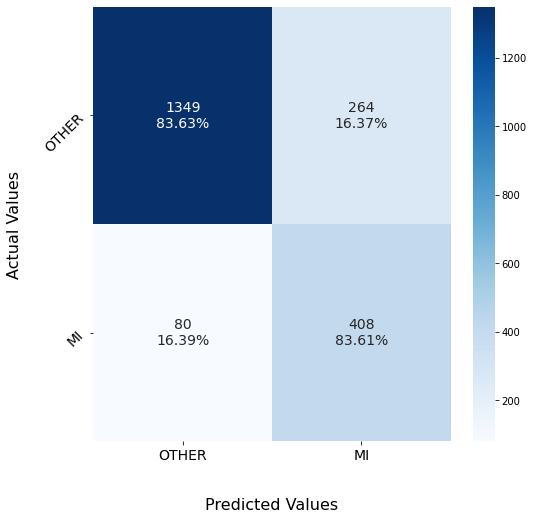

In [188]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['equal_confusion_matrix'])

**Recall = 90%**

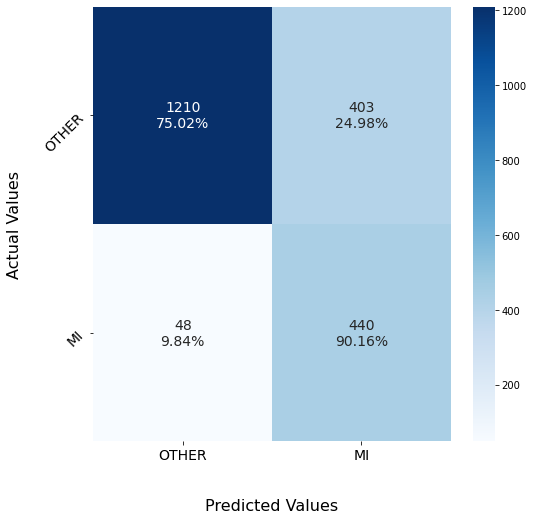

In [189]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['target_confusion_matrix'])

# =============================================================

#### Binary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Dropout + Age + Sex

# =============================================================

In general, we only use the ECG as input. However, in some models we add additional variables.

In [190]:
train_x = (train_set_x, train_set_age_n_sex)
val_x = (val_set_x, val_set_age_n_sex)
test_x = (test_set_x, test_set_age_n_sex)

Define the model id. This must be different from any other since we are not overwritting.

In [191]:
model_id     =  'ks_bn_l1_dr_as_1'
model_path   =  models_path + model_id
result_path  =  results_path + model_id

Load the model if it has been created, else create a new instance of it.

In [192]:
try:
    os.listdir(model_path)
    model = tf.keras.models.load_model(model_path + '/model.h5')
    fitted_model = pd.read_csv(result_path + '/history.csv', index_col=0)
    found = True
    
except FileNotFoundError:
    ecg.make_dir(model_path)
    ecg.make_dir(result_path)    
    found = False

Define the architecture of the network.

In [193]:
if not found:
    
    ### Convolutional Model
    conv_input = Input(shape=(img_h, img_w))

    x = Conv1D(128, 14, activation='relu', strides=3, padding="same")(conv_input)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(256, 14, activation='relu', strides=3, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006))(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Model(inputs = conv_input, outputs = x)
    
    
    ### Age and Sex Model
    wide_input = Input(shape=(2,))    
    y = Dense(10, activation='relu')(wide_input)    
    y = Model(inputs = wide_input, outputs = y)
        
    ### Combined Model
    combined = concatenate([x.output, y.output])
    z = Dense(d_model, activation='relu')(combined)
    z = Dense(len(Y.columns), activation='sigmoid')(z)

    model = Model(inputs=[x.input, y.input], outputs=z)
    
print('Number of parameters:')    
ecg.get_number_of_parameters(model, path = model_path)    

Number of parameters:
Total params:  2,060,703
Trainable params:  2,058,911
Non-trainable params:  1,792


Train the model.

In [194]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_to_track)

    # Train
    fitted_model = model.fit(train_x, train_set_y, steps_per_epoch=batches,
                             epochs=epochs, validation_data=(val_x, val_set_y),                                 
                             callbacks=[EarlyStopping(monitor='val_loss', patience=patience)])
    
    # Save
    model.save(model_path + '/model.h5')
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv(result_path + '/history.csv')

Epoch 1/100
229/229 [==============================] - 15s 55ms/step - loss: 1.2795 - accuracy: 0.7458 - val_loss: 0.6303 - val_accuracy: 0.7344
Epoch 2/100
229/229 [==============================] - 12s 52ms/step - loss: 0.5142 - accuracy: 0.7938 - val_loss: 0.4887 - val_accuracy: 0.7894
Epoch 3/100
229/229 [==============================] - 12s 53ms/step - loss: 0.4554 - accuracy: 0.8127 - val_loss: 0.4451 - val_accuracy: 0.8313
Epoch 4/100
229/229 [==============================] - 12s 53ms/step - loss: 0.4330 - accuracy: 0.8237 - val_loss: 0.4177 - val_accuracy: 0.8191
Epoch 5/100
229/229 [==============================] - 12s 53ms/step - loss: 0.4177 - accuracy: 0.8277 - val_loss: 0.3994 - val_accuracy: 0.8289
Epoch 6/100
229/229 [==============================] - 12s 53ms/step - loss: 0.4073 - accuracy: 0.8331 - val_loss: 0.3865 - val_accuracy: 0.8372
Epoch 7/100
229/229 [==============================] - 12s 54ms/step - loss: 0.3980 - accuracy: 0.8388 - val_loss: 0.4168 - val_ac

Monitor the training and validation loss.

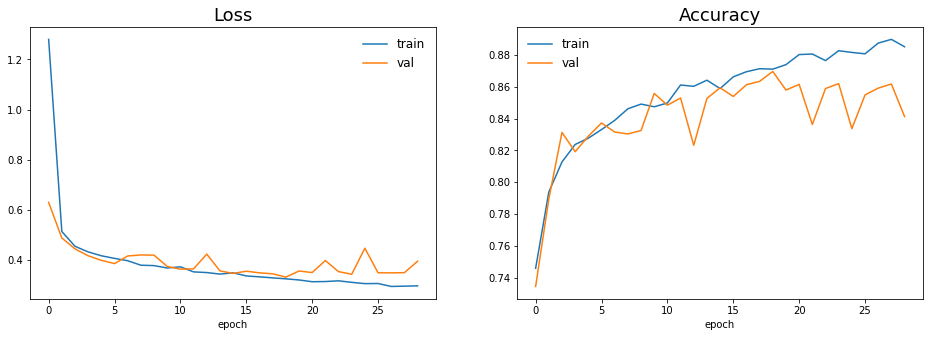

In [195]:
ecg.plot_model_history(fitted_model)

### Metrics

We calculate some metrics to further compare the models. We do all of this using the test set, since that would help us better represent how the models will perform in new data.

In the case of MI prediction, we will look at the results in 3 ways:
    
    1. Using a threshold of 0.5 to determine MI vs Other:
       This one is probably the least important, we only include it since a threshold
       of 0.5 is the most standard way to evaluate  classification problems
       
    2. Equalize recall and specificity:
       This approach has the goal to optimize both recall and specificity as much as possible.
       
    3. Optimize recall:
       We will define a target recall, 90% specifically, and visualize how the other metrics
       behave conditional on this.

In [196]:
# Set the threshold and target recall
threshold      =  0.5
target_recall  =  0.9

if not found:
    # Calculate the metrics given test predictions 
    test_pred, test_score    =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
    test_metrics             =  ecg.calculate_metrics_mi(test_set_y.numpy(), test_pred, test_score,
                                                         target_recall=target_recall)

    # Save the metrics
    with open(result_path + '/metrics.pickle', 'wb') as handle:
        pickle.dump(test_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    num_metrics = {key : values for key, values in test_metrics.items() if ecg.filter_metric(key)}
    pd.Series(num_metrics).to_csv(result_path + '/metrics.csv')

# Retrieve the metrics
with open(result_path + '/metrics.pickle', 'rb') as handle:
    test_metrics = pickle.load(handle)
    
# Obtain  fpr and tpr to plot the ROC curve
fpr, tpr, thresholds = test_metrics['roc_curve']
include_points = {'' : 'orange', 'equal_' : 'green', 'target_' : 'red',}

#### ROC Curve

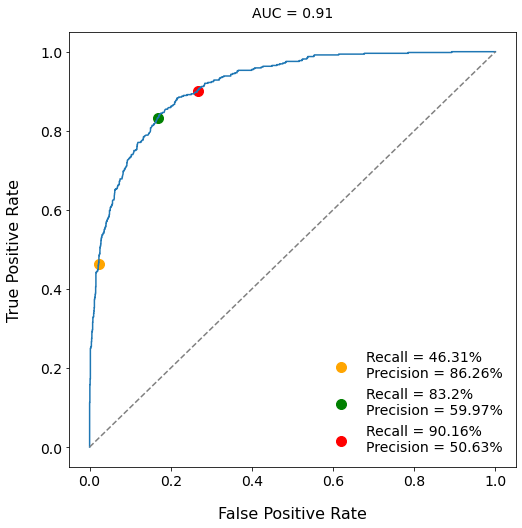

In [197]:
ecg.plot_roc_curve_mi(fpr, tpr, test_metrics, include_points)

**Threshold = 50%**

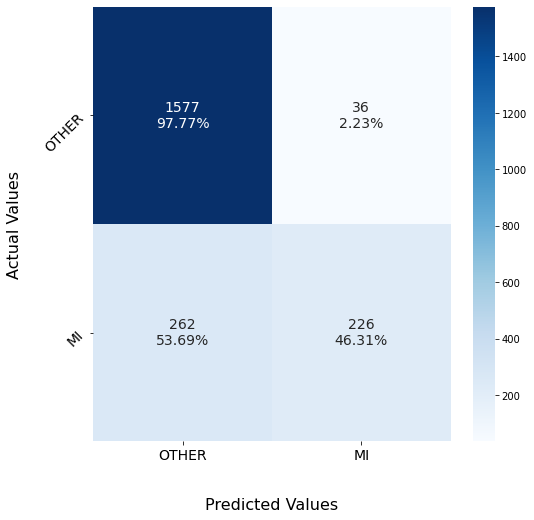

In [198]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['confusion_matrix'])

**Recall = Specificity**

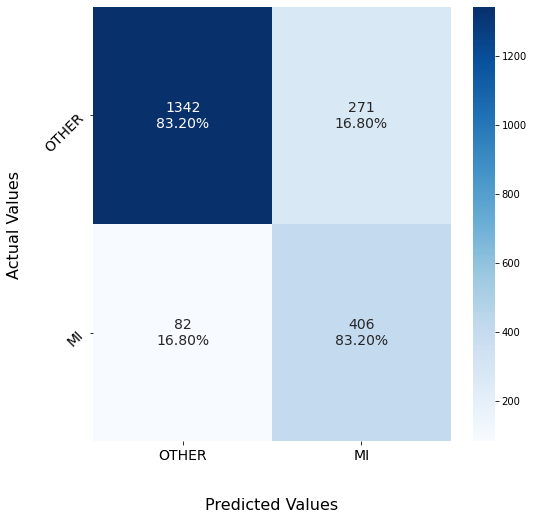

In [199]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['equal_confusion_matrix'])

**Recall = 90%**

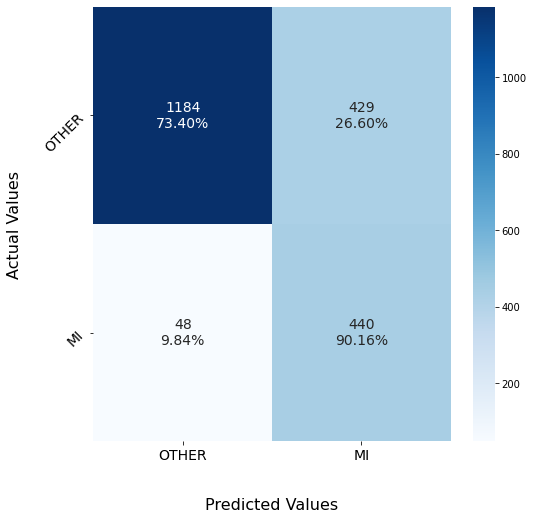

In [200]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['target_confusion_matrix'])

# =============================================================

#### Binary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Dropout + Age + Sex + LR Reduce

# =============================================================

For LR reduction, we need to define a new object, and then add it to the callbacks.

In [202]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=0)

In general, we only use the ECG as input. However, in some models we add additional variables.

In [203]:
train_x = (train_set_x, train_set_age_n_sex)
val_x = (val_set_x, val_set_age_n_sex)
test_x = (test_set_x, test_set_age_n_sex)

Define the model id. This must be different from any other since we are not overwritting.

In [204]:
model_id     =  'ks_bn_l1_dr_as_lr_1'
model_path   =  models_path + model_id
result_path  =  results_path + model_id

Load the model if it has been created, else create a new instance of it.

In [205]:
try:
    os.listdir(model_path)
    model = tf.keras.models.load_model(model_path + '/model.h5')
    fitted_model = pd.read_csv(result_path + '/history.csv', index_col=0)
    found = True
    
except FileNotFoundError:
    ecg.make_dir(model_path)
    ecg.make_dir(result_path)    
    found = False

Define the architecture of the network.

In [206]:
if not found:
    
    ### Convolutional Model
    conv_input = Input(shape=(img_h, img_w))

    x = Conv1D(128, 14, activation='relu', strides=3, padding="same")(conv_input)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(256, 14, activation='relu', strides=3, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006))(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Model(inputs = conv_input, outputs = x)
    
    
    ### Age and Sex Model
    wide_input = Input(shape=(2,))    
    y = Dense(10, activation='relu')(wide_input)    
    y = Model(inputs = wide_input, outputs = y)
        
    ### Combined Model
    combined = concatenate([x.output, y.output])
    z = Dense(d_model, activation='relu')(combined)
    z = Dense(len(Y.columns), activation='sigmoid')(z)

    model = Model(inputs=[x.input, y.input], outputs=z)
    
print('Number of parameters:')    
ecg.get_number_of_parameters(model, path = model_path)    

Number of parameters:
Total params:  2,060,703
Trainable params:  2,058,911
Non-trainable params:  1,792


Train the model.

In [207]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_to_track)

    # Train
    fitted_model = model.fit(train_x, train_set_y, steps_per_epoch=batches,
                             epochs=epochs, validation_data=(val_x, val_set_y),                                 
                             callbacks=[EarlyStopping(monitor='val_loss', patience=patience), 
                                        reduce_lr]) # Add LR Reduction
    
    # Save
    model.save(model_path + '/model.h5')
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv(result_path + '/history.csv')

Epoch 1/100
229/229 [==============================] - 14s 52ms/step - loss: 1.2354 - accuracy: 0.7524 - val_loss: 0.5937 - val_accuracy: 0.7399 - lr: 0.0010
Epoch 2/100
229/229 [==============================] - 12s 51ms/step - loss: 0.4825 - accuracy: 0.8043 - val_loss: 0.5117 - val_accuracy: 0.7589 - lr: 0.0010
Epoch 3/100
229/229 [==============================] - 12s 50ms/step - loss: 0.4431 - accuracy: 0.8136 - val_loss: 0.4548 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 4/100
229/229 [==============================] - 12s 51ms/step - loss: 0.4166 - accuracy: 0.8281 - val_loss: 0.4149 - val_accuracy: 0.8258 - lr: 0.0010
Epoch 5/100
229/229 [==============================] - 12s 51ms/step - loss: 0.4009 - accuracy: 0.8341 - val_loss: 0.4465 - val_accuracy: 0.8046 - lr: 0.0010
Epoch 6/100
229/229 [==============================] - 12s 51ms/step - loss: 0.3893 - accuracy: 0.8409 - val_loss: 0.3706 - val_accuracy: 0.8439 - lr: 0.0010
Epoch 7/100
229/229 [==============================]

Monitor the training and validation loss.

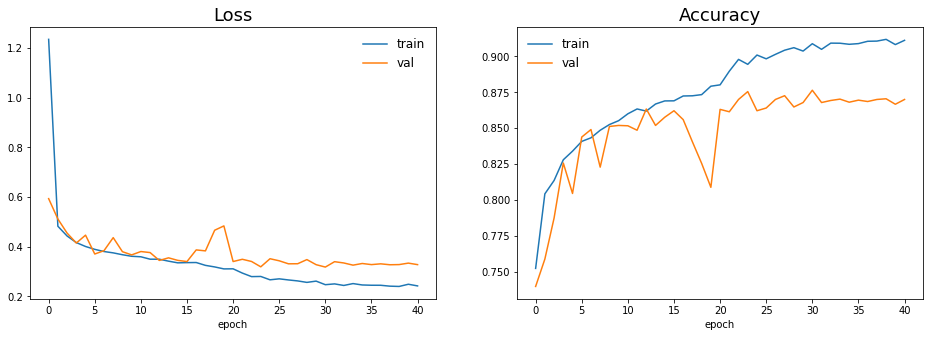

In [208]:
ecg.plot_model_history(fitted_model)

### Metrics

We calculate some metrics to further compare the models. We do all of this using the test set, since that would help us better represent how the models will perform in new data.

In the case of MI prediction, we will look at the results in 3 ways:
    
    1. Using a threshold of 0.5 to determine MI vs Other:
       This one is probably the least important, we only include it since a threshold
       of 0.5 is the most standard way to evaluate  classification problems
       
    2. Equalize recall and specificity:
       This approach has the goal to optimize both recall and specificity as much as possible.
       
    3. Optimize recall:
       We will define a target recall, 90% specifically, and visualize how the other metrics
       behave conditional on this.

In [209]:
# Set the threshold and target recall
threshold      =  0.5
target_recall  =  0.9

if not found:
    # Calculate the metrics given test predictions 
    test_pred, test_score    =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
    test_metrics             =  ecg.calculate_metrics_mi(test_set_y.numpy(), test_pred, test_score,
                                                         target_recall=target_recall)

    # Save the metrics
    with open(result_path + '/metrics.pickle', 'wb') as handle:
        pickle.dump(test_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    num_metrics = {key : values for key, values in test_metrics.items() if ecg.filter_metric(key)}
    pd.Series(num_metrics).to_csv(result_path + '/metrics.csv')

# Retrieve the metrics
with open(result_path + '/metrics.pickle', 'rb') as handle:
    test_metrics = pickle.load(handle)
    
# Obtain  fpr and tpr to plot the ROC curve
fpr, tpr, thresholds = test_metrics['roc_curve']
include_points = {'' : 'orange', 'equal_' : 'green', 'target_' : 'red',}

#### ROC Curve

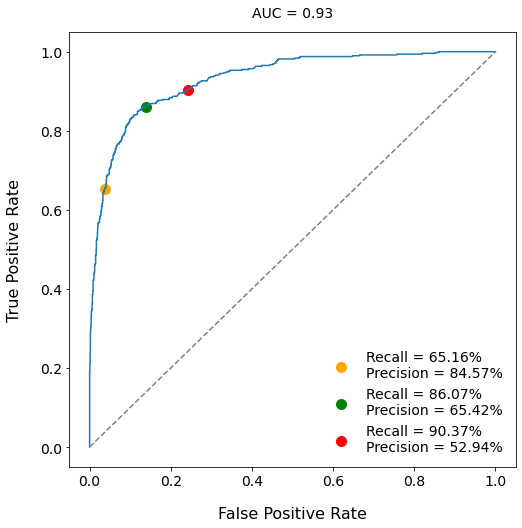

In [210]:
ecg.plot_roc_curve_mi(fpr, tpr, test_metrics, include_points)

**Threshold = 50%**

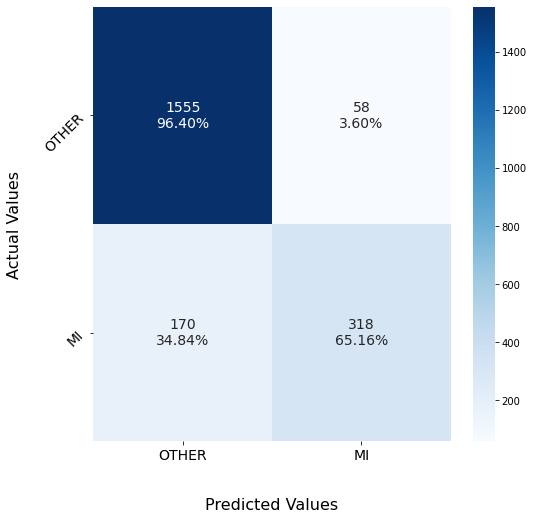

In [211]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['confusion_matrix'])

**Recall = Specificity**

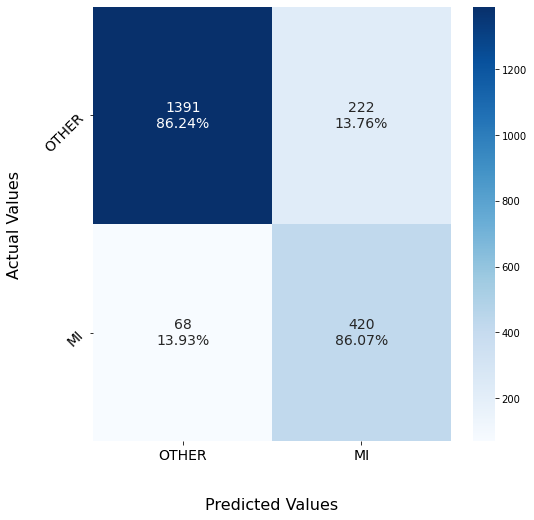

In [212]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['equal_confusion_matrix'])

**Recall = 90%**

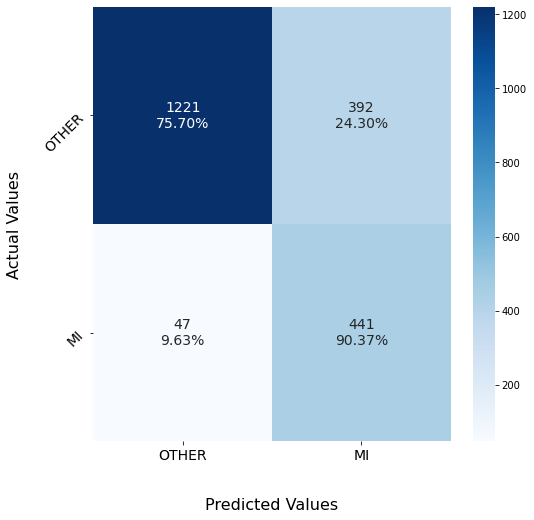

In [213]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['target_confusion_matrix'])

# =============================================================

#### Binary - Adding different Kernel and Stride Sizes + BatchNormalization + L1 Regularizer + Droput  + Age + Sex +  LR Reduce + Class Weights

# =============================================================

For LR reduction, we need to define a new object, and then add it to the callbacks.

In [228]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=14, verbose=0)

We define the class weights that will be passed to give more importance to certain classes. We will also use a different parameter for the patience since assigning weight to a class can make the validation loss very erratic and the training loss will be moving very slowly.

In [229]:
class_weight = {0 : 1, 1 : 10}
cw_patience = 30

In general, we only use the ECG as input. However, in some models we add additional variables.

In [230]:
train_x = (train_set_x, train_set_age_n_sex)
val_x = (val_set_x, val_set_age_n_sex)
test_x = (test_set_x, test_set_age_n_sex)

Define the model id. This must be different from any other since we are not overwritting.

In [231]:
model_id     =  'ks_bn_l1_dr_as_lr_cw_1'
model_path   =  models_path + model_id
result_path  =  results_path + model_id

Load the model if it has been created, else create a new instance of it.

In [232]:
try:
    os.listdir(model_path)
    model = tf.keras.models.load_model(model_path + '/model.h5')
    fitted_model = pd.read_csv(result_path + '/history.csv', index_col=0)
    found = True
    
except FileNotFoundError:
    ecg.make_dir(model_path)
    ecg.make_dir(result_path)    
    found = False

Define the architecture of the network.

In [233]:
if not found:
    
    ### Convolutional Model
    conv_input = Input(shape=(img_h, img_w))

    x = Conv1D(128, 14, activation='relu', strides=3, padding="same")(conv_input)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(256, 14, activation='relu', strides=3, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same")(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Conv1D(d_model, 10, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006))(x)
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Model(inputs = conv_input, outputs = x)
    
    
    ### Age and Sex Model
    wide_input = Input(shape=(2,))    
    y = Dense(10, activation='relu')(wide_input)    
    y = Model(inputs = wide_input, outputs = y)
        
    ### Combined Model
    combined = concatenate([x.output, y.output])
    z = Dense(d_model, activation='relu')(combined)
    z = Dense(len(Y.columns), activation='sigmoid')(z)

    model = Model(inputs=[x.input, y.input], outputs=z)
    
print('Number of parameters:')    
ecg.get_number_of_parameters(model, path = model_path)    

Number of parameters:
Total params:  2,060,703
Trainable params:  2,058,911
Non-trainable params:  1,792


Train the model.

In [234]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_to_track)

    # Train
    fitted_model = model.fit(train_x, train_set_y, steps_per_epoch=batches,
                             epochs=epochs, validation_data=(val_x, val_set_y),                                 
                             callbacks=[EarlyStopping(monitor='val_loss', 
                                                      patience=cw_patience), # Change patience
                                        reduce_lr], # Add LR Reduction
                             class_weight=class_weight) # Add class weights
    
    # Save
    model.save(model_path + '/model.h5')
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv(result_path + '/history.csv')

Epoch 1/100
229/229 [==============================] - 16s 55ms/step - loss: 3.2358 - accuracy: 0.4826 - val_loss: 0.7511 - val_accuracy: 0.7004 - lr: 0.0010
Epoch 2/100
229/229 [==============================] - 12s 54ms/step - loss: 1.4246 - accuracy: 0.5336 - val_loss: 0.8186 - val_accuracy: 0.6019 - lr: 0.0010
Epoch 3/100
229/229 [==============================] - 12s 54ms/step - loss: 1.3094 - accuracy: 0.5785 - val_loss: 0.9667 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 4/100
229/229 [==============================] - 12s 54ms/step - loss: 1.2652 - accuracy: 0.5959 - val_loss: 0.8144 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 5/100
229/229 [==============================] - 12s 54ms/step - loss: 1.2128 - accuracy: 0.6102 - val_loss: 0.8339 - val_accuracy: 0.5735 - lr: 0.0010
Epoch 6/100
229/229 [==============================] - 13s 55ms/step - loss: 1.1789 - accuracy: 0.6185 - val_loss: 0.8730 - val_accuracy: 0.5702 - lr: 0.0010
Epoch 7/100
229/229 [==============================]

Monitor the training and validation loss.

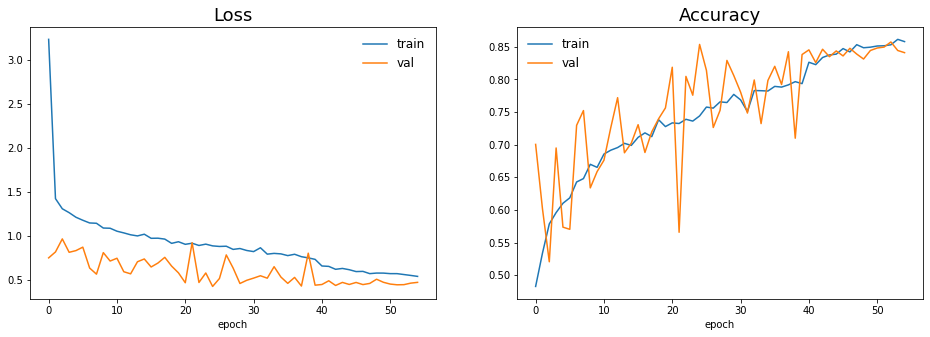

In [235]:
ecg.plot_model_history(fitted_model)

### Metrics

We calculate some metrics to further compare the models. We do all of this using the test set, since that would help us better represent how the models will perform in new data.

In the case of MI prediction, we will look at the results in 3 ways:
    
    1. Using a threshold of 0.5 to determine MI vs Other:
       This one is probably the least important, we only include it since a threshold
       of 0.5 is the most standard way to evaluate  classification problems
       
    2. Equalize recall and specificity:
       This approach has the goal to optimize both recall and specificity as much as possible.
       
    3. Optimize recall:
       We will define a target recall, 90% specifically, and visualize how the other metrics
       behave conditional on this.

In [236]:
# Set the threshold and target recall
threshold      =  0.5
target_recall  =  0.9

if not found:
    # Calculate the metrics given test predictions 
    test_pred, test_score    =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
    test_metrics             =  ecg.calculate_metrics_mi(test_set_y.numpy(), test_pred, test_score,
                                                         target_recall=target_recall)

    # Save the metrics
    with open(result_path + '/metrics.pickle', 'wb') as handle:
        pickle.dump(test_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    num_metrics = {key : values for key, values in test_metrics.items() if ecg.filter_metric(key)}
    pd.Series(num_metrics).to_csv(result_path + '/metrics.csv')

# Retrieve the metrics
with open(result_path + '/metrics.pickle', 'rb') as handle:
    test_metrics = pickle.load(handle)
    
# Obtain  fpr and tpr to plot the ROC curve
fpr, tpr, thresholds = test_metrics['roc_curve']
include_points = {'' : 'orange', 'equal_' : 'green', 'target_' : 'red',}

#### ROC Curve

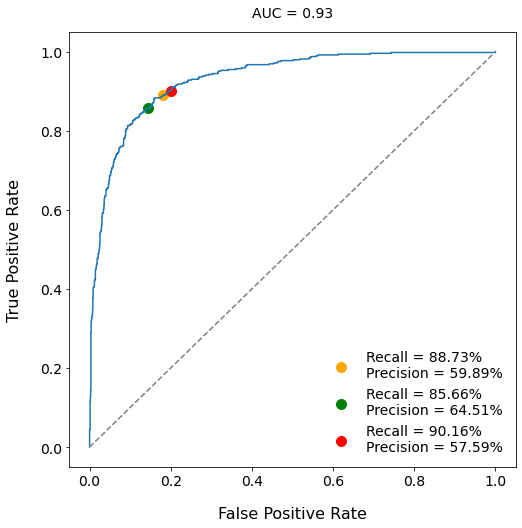

In [237]:
ecg.plot_roc_curve_mi(fpr, tpr, test_metrics, include_points)

**Threshold = 50%**

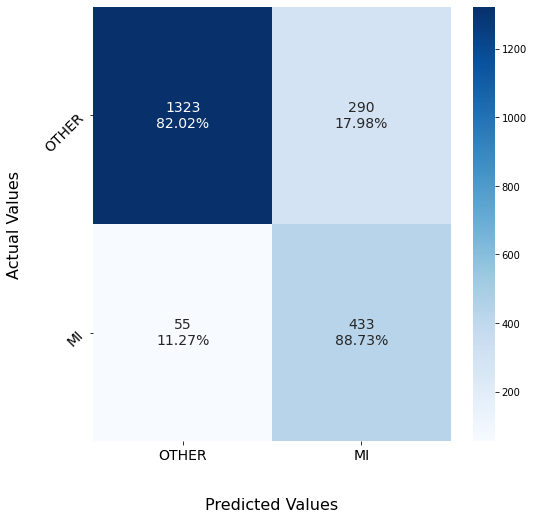

In [238]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['confusion_matrix'])

**Recall = Specificity**

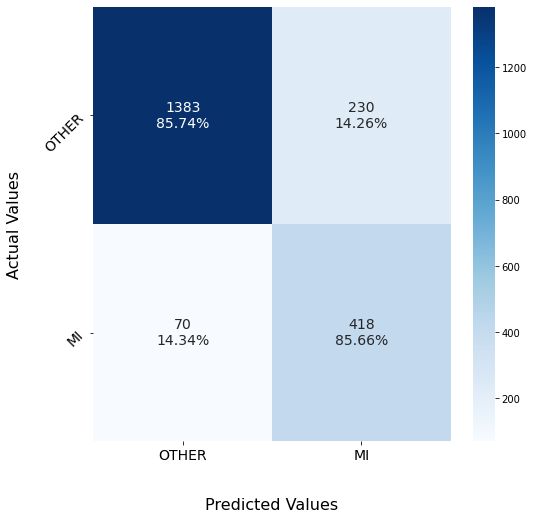

In [239]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['equal_confusion_matrix'])

**Recall = 90%**

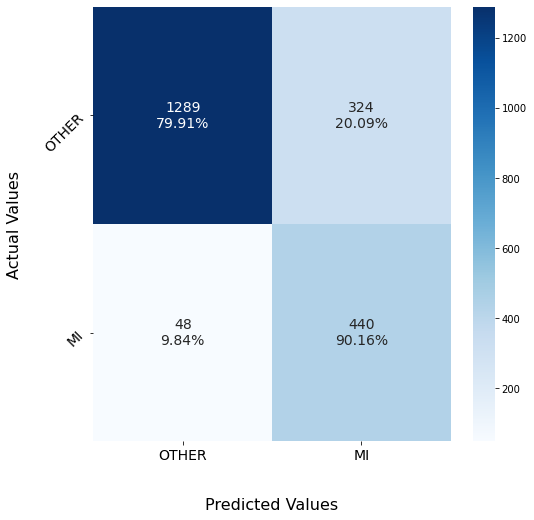

In [240]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['target_confusion_matrix'])

# =============================================================

####  Binary - https://www.nature.com/articles/s41467-020-15432-4

# =============================================================

In general, we only use the ECG as input. However, in some models we add additional variables.

In [817]:
train_x = train_set_x
val_x = val_set_x
test_x = test_set_x

Define the model id. This must be different from any other since we are not overwritting.

In [818]:
model_id     =  'antonior92'
model_path   =  models_path + model_id
result_path  =  results_path + model_id

Load the model if it has been created, else create a new instance of it.

In [819]:
try:
    os.listdir(model_path)
    model = tf.keras.models.load_model(model_path + '/model.h5')
    fitted_model = pd.read_csv(result_path + '/history.csv', index_col=0)
    found = True
    
except FileNotFoundError:
    ecg.make_dir(model_path)
    ecg.make_dir(result_path)    
    found = False

Define the architecture of the network.

In [820]:
if not found:
    
    model = get_model(1, input_shape=(img_h, img_w))
    
print('Number of parameters:')    
ecg.get_number_of_parameters(model, path = model_path)    

Number of parameters:
Total params:  6,400,993
Trainable params:  6,397,265
Non-trainable params:  3,728


Train the model.

In [821]:
if not found:

    # Compile
    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_to_track)

    # Train
    fitted_model = model.fit(train_x, train_set_y, steps_per_epoch=batches,
                             epochs=epochs, validation_data=(val_x, val_set_y),                                 
                             callbacks=[EarlyStopping(monitor='val_loss', patience=patience)])
    
    # Save
    model.save(model_path + '/model.h5')
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv(result_path + '/history.csv')

Epoch 1/100
229/229 [==============================] - 127s 535ms/step - loss: 0.4550 - accuracy: 0.7980 - val_loss: 0.4464 - val_accuracy: 0.7953
Epoch 2/100
229/229 [==============================] - 175s 764ms/step - loss: 0.3632 - accuracy: 0.8482 - val_loss: 0.3844 - val_accuracy: 0.8353
Epoch 3/100
229/229 [==============================] - 171s 749ms/step - loss: 0.3265 - accuracy: 0.8651 - val_loss: 0.3515 - val_accuracy: 0.8591
Epoch 4/100
229/229 [==============================] - 180s 787ms/step - loss: 0.2935 - accuracy: 0.8800 - val_loss: 0.3173 - val_accuracy: 0.8663
Epoch 5/100
229/229 [==============================] - 177s 773ms/step - loss: 0.2920 - accuracy: 0.8794 - val_loss: 0.4475 - val_accuracy: 0.8475
Epoch 6/100
229/229 [==============================] - 177s 772ms/step - loss: 0.2715 - accuracy: 0.8895 - val_loss: 0.3434 - val_accuracy: 0.8713
Epoch 7/100
229/229 [==============================] - 172s 750ms/step - loss: 0.2710 - accuracy: 0.8889 - val_loss: 0

Monitor the training and validation loss.

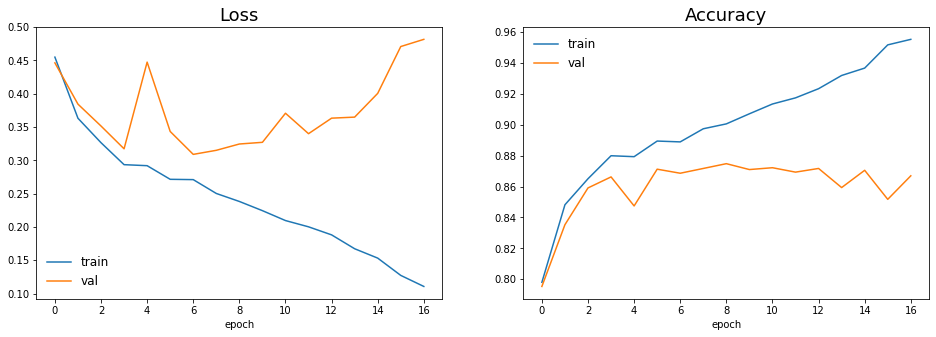

In [822]:
ecg.plot_model_history(fitted_model)

### Metrics

We calculate some metrics to further compare the models. We do all of this using the test set, since that would help us better represent how the models will perform in new data.

In the case of MI prediction, we will look at the results in 3 ways:
    
    1. Using a threshold of 0.5 to determine MI vs Other:
       This one is probably the least important, we only include it since a threshold
       of 0.5 is the most standard way to evaluate  classification problems
       
    2. Equalize recall and specificity:
       This approach has the goal to optimize both recall and specificity as much as possible.
       
    3. Optimize recall:
       We will define a target recall, 90% specifically, and visualize how the other metrics
       behave conditional on this.

In [823]:
# Set the threshold and target recall
threshold      =  0.5
target_recall  =  0.9

if not found:
    # Calculate the metrics given test predictions 
    test_pred, test_score    =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
    test_metrics             =  ecg.calculate_metrics_mi(test_set_y.numpy(), test_pred, test_score,
                                                         target_recall=target_recall)

    # Save the metrics
    with open(result_path + '/metrics.pickle', 'wb') as handle:
        pickle.dump(test_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    num_metrics = {key : values for key, values in test_metrics.items() if ecg.filter_metric(key)}
    pd.Series(num_metrics).to_csv(result_path + '/metrics.csv')

# Retrieve the metrics
with open(result_path + '/metrics.pickle', 'rb') as handle:
    test_metrics = pickle.load(handle)
    
# Obtain  fpr and tpr to plot the ROC curve
fpr, tpr, thresholds = test_metrics['roc_curve']
include_points = {'' : 'orange', 'equal_' : 'green', 'target_' : 'red',}

#### ROC Curve

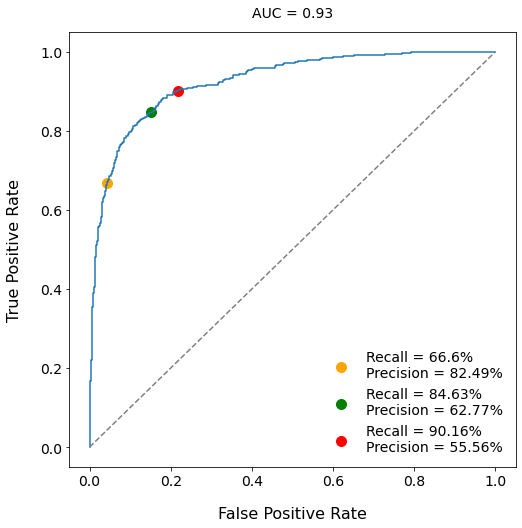

In [824]:
ecg.plot_roc_curve_mi(fpr, tpr, test_metrics, include_points)

**Threshold = 50%**

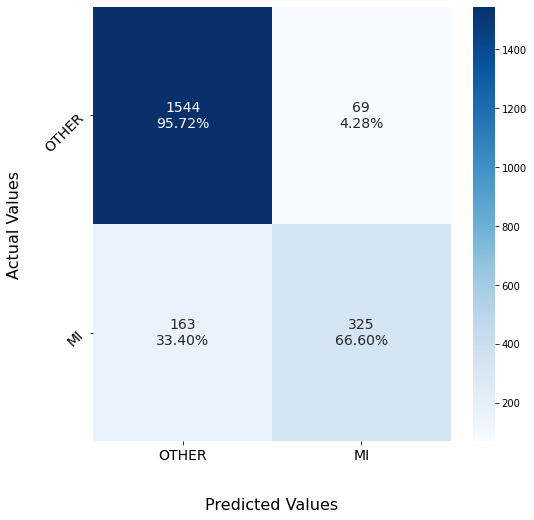

In [825]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['confusion_matrix'])

**Recall = Specificity**

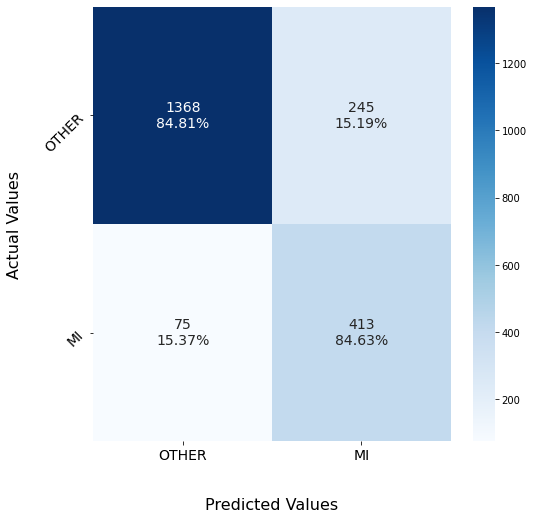

In [826]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['equal_confusion_matrix'])

**Recall = 90%**

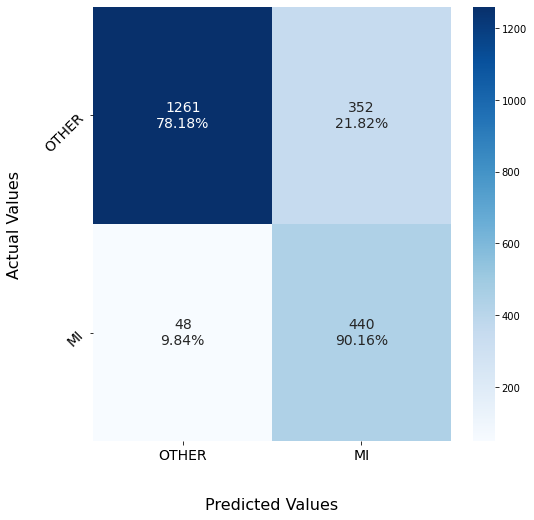

In [827]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['target_confusion_matrix'])

## Comparing Models

Having run different combinations for the models, we are now interested in verifying which has the best performance. We will also check if having used a median filtering or removing outliers was beneficial to the model's predictive power.

In [13]:
results = dict()
for idx, path in path_dict.items():
    try:
        
        cutpaths = os.listdir('results/' + path + labels_id + '/')     
        
        for cutpath in cutpaths:
            
            cutpath = 'results/' + path + labels_id + '/' + cutpath + '/'
            subpaths = os.listdir(cutpath)
            
            for subpath in subpaths:

                fullpath = cutpath + subpath + '/'
                path_metrics = pd.read_csv(fullpath + 'metrics.csv', index_col=0)
                model_id = f"{idx}_ct_{fullpath.split('_ct_')[-1].split('/')[0]}_{fullpath.split('/')[-2]}"
                path_metrics.columns = [model_id]
                results[model_id] = path_metrics
                
    except FileNotFoundError:
        pass
    
results = pd.concat([result for result in results.values()], axis=1)
results = results.transpose()
results = 100 * results
results = results.applymap(lambda x : round(x, 2))

With the comparisons in this section, we later tried to optimize a model. These are also stored in the same paths, so we remove them from the comparison analysis.

In [14]:
results = results.loc[[idx for idx in results.index if 'optim' not in idx]]

These are the top 5 with respect to ROC AUC.

In [15]:
results.sort_values(by='roc_auc', ascending=False).head(5)

,roc_auc,recall,precision,specificity,f1,accuracy,target_recall,target_precision,target_specificity,target_f1,target_accuracy,equal_recall,equal_precision,equal_specificity,equal_f1,equal_accuracy
mf_200_ct_0.3_ol_5_25_ks_bn_l1_dr_as_lr_cw_1,93.57,85.25,65.62,86.48,74.15,86.20,90.57,55.81,78.30,69.06,81.15,85.45,64.06,85.49,73.22,85.48
og_ct_0.5_ol_5_25_ks_bn_l1_dr_as_lr_1,93.18,65.16,84.57,96.40,73.61,89.15,90.37,52.94,75.70,66.77,79.11,86.07,65.42,86.24,74.34,86.20
og_ct_0.5_ol_5_25_ks_bn_l1_dr_as_lr_cw_1,93.17,88.73,59.89,82.02,71.51,83.58,90.16,57.59,79.91,70.29,82.29,85.66,64.51,85.74,73.59,85.72
mf_200_ct_0.3_ol_5_25_ks_bn_l1_dr_as_lr_1,93.09,68.03,83.21,95.85,74.86,89.39,90.16,56.70,79.17,69.62,81.72,84.63,62.67,84.75,72.01,84.72
og_ct_0.5_ks_bn_l1_dr_as_lr_1,92.94,62.33,83.38,96.09,71.33,88.00,90.06,58.66,80.01,71.04,82.42,85.85,65.93,86.03,74.58,85.99


These are the bottom 5 with respect to ROC AUC.

In [16]:
results.sort_values(by='roc_auc', ascending=False).tail(5)

,roc_auc,recall,precision,specificity,f1,accuracy,target_recall,target_precision,target_specificity,target_f1,target_accuracy,equal_recall,equal_precision,equal_specificity,equal_f1,equal_accuracy
mf_200_ct_0.3_ol_5_25_1,87.59,68.03,62.64,87.72,65.23,83.15,90.16,41.20,61.07,56.56,67.82,79.10,53.84,79.48,64.07,79.39
og_ct_0.3_ol_5_25_1,86.19,62.09,62.60,88.78,62.35,82.58,90.37,39.84,58.71,55.30,66.06,78.69,53.04,78.92,63.37,78.87
og_ct_0.5_ol_5_25_1,85.74,62.70,63.88,89.27,63.29,83.10,90.16,38.56,56.54,54.02,64.35,77.25,50.88,77.43,61.35,77.39
og_ct_0.3_1,85.36,66.35,65.47,88.98,65.91,83.56,90.06,38.17,54.06,53.61,62.68,78.01,52.92,78.15,63.06,78.11
og_ct_0.5_1,85.28,57.17,70.35,92.41,63.08,83.97,90.06,38.67,55.03,54.11,63.42,78.01,52.92,78.15,63.06,78.11


We would like to know if there are certain elements that contributed more towards improving the model's metrics. We first set some filters on which models we will compare.

In [17]:
cut_filter = [idx for idx in results.index if 'ct_0.3' in idx]
filters = [idx for idx in cut_filter if 'antonior92' not in idx]

We ran each element in succession: we first changed the kernel and stride to more sensible values, then we added batch normalization, then L1 regularization, and so on. For this reason, the following plots will not be necessarily correct, since we are only accounting for consecutive contributions and will not be able to retrieve the exact effect of using the determined element. 

For example, L1 regularization was implemented before dropout. As we see in the graphs below, it would seem that L1 contributed more than dropout, but what if we had implemented them in the reverse order? They are both used to account for regularization, so maybe they are doing almost the same, but the order in which we ran the models shows that L1 worked "better". 

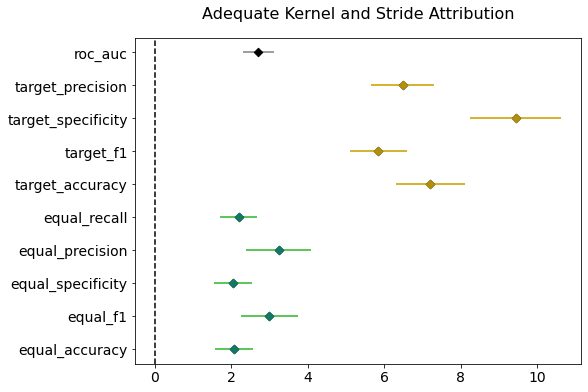

In [18]:
ecg.element_attribution_mi(results, 'ks', filters)

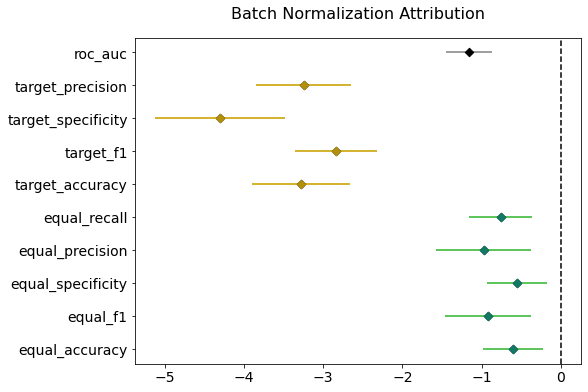

In [19]:
ecg.element_attribution_mi(results, 'bn', filters)

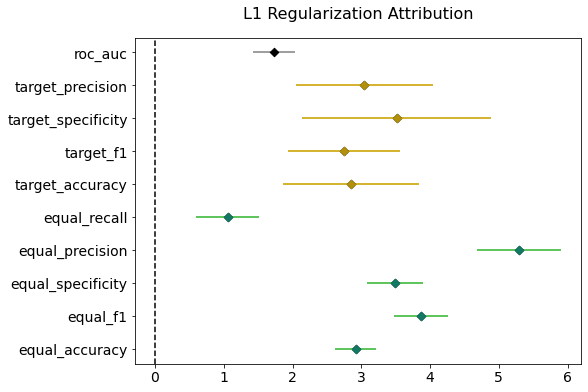

In [20]:
ecg.element_attribution_mi(results, 'l1', filters)

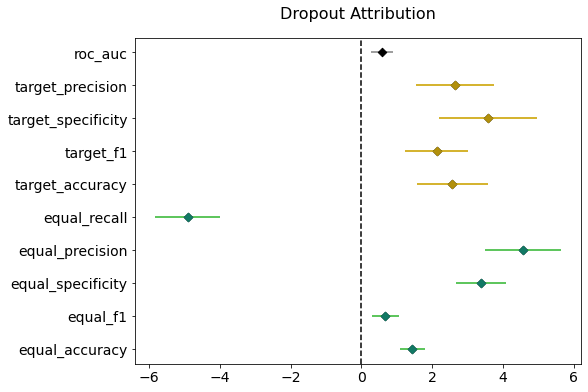

In [21]:
ecg.element_attribution_mi(results, 'dr', filters)

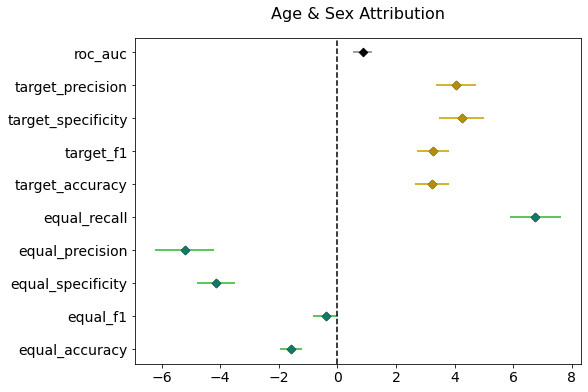

In [22]:
ecg.element_attribution_mi(results, 'as', filters)

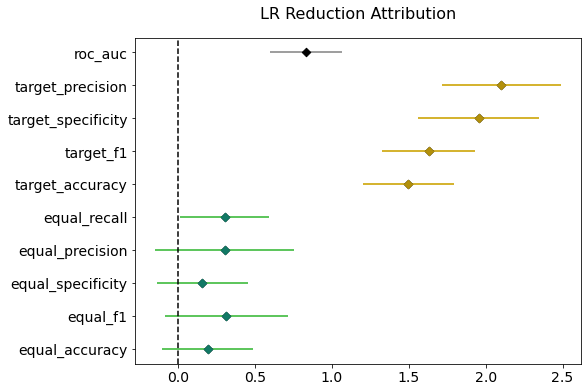

In [23]:
ecg.element_attribution_mi(results, 'lr', filters)

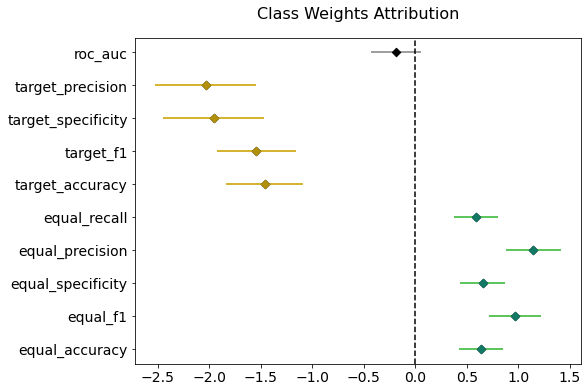

In [24]:
ecg.element_attribution_mi(results, 'cw', filters)

Having used more data (50% instead of 30%) had a somewhat positiive effect on the metrics.

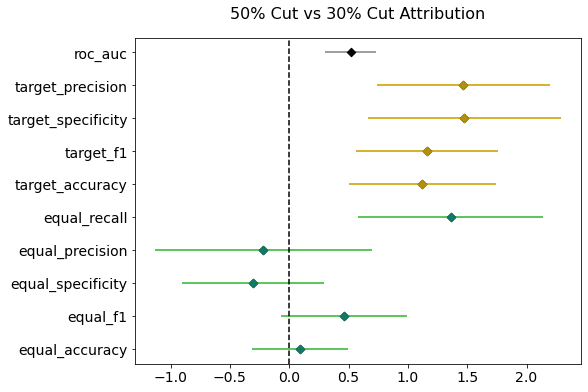

In [25]:
filters = [idx for idx in results.index if 'og' in idx]
filters = [idx for idx in results.index if 'antonior92' not in idx]

ecg.cut_increase_attribution_mi(results, str(0.3), str(0.5), filters)

Having used the median filter, on average, helped on every single metric.

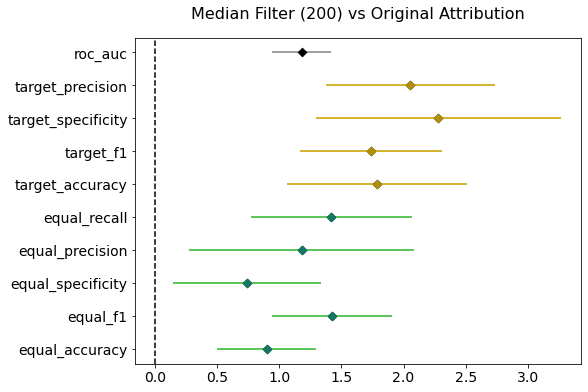

In [26]:
filters = [idx for idx in results.index if 'ct_0.3' in idx]
filters = [idx for idx in results.index if 'antonior92' not in idx]

pre_1 = 'og'
pre_2 = 'mf_200'

ecg.preproc_attribution_mi(results, pre_1, pre_2, filters)

Removing the outliers seems to have, on average, been worse for the model. This goes to tell how powerfull the CNNs are, as in that they can filter out the noise and look only at the important things in the signals.

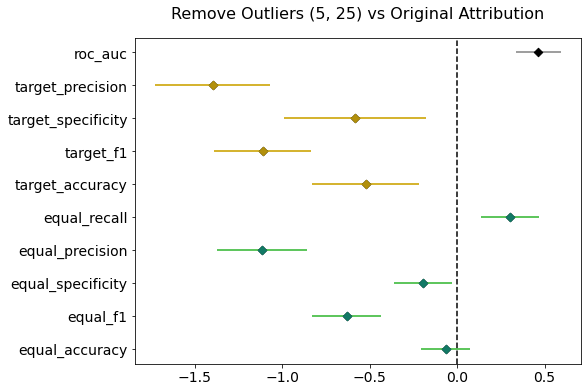

In [27]:
filters = [idx for idx in results.index if 'ct_0.3' in idx]
filters = [idx for idx in results.index if 'antonior92' not in idx]

ecg.outlier_removal_attribution_mi(results, 'ol_5_25', filters)
# ecg.outlier_removal_attribution_mi_2(results, 'ol_5_25', filters)

## Optimizing the Model

Increase number of epochs in case it is needed

In [56]:
epochs = 200

For these runs, we are going to also tweek the optimizer.

In [57]:
optim_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00006)

For LR reduction, we need to define a new object, and then add it to the callbacks.

In [58]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=12, verbose=0)

We define the class weights that will be passed to give more importance to certain classes. We will also use a different parameter for the patience since assigning weight to a class can make the validation loss very erratic and the training loss will be moving very slowly.

In [59]:
# class_weight = {0 : 1, 1 : 10}
class_weight = {0 : 1, 1 : 8}
cw_patience = 30

In general, we only use the ECG as input. However, in some models we add additional variables.

In [60]:
train_x = (train_set_x, train_set_age_n_sex)
val_x = (val_set_x, val_set_age_n_sex)
test_x = (test_set_x, test_set_age_n_sex)

Define the model id. This must be different from any other since we are not overwritting.

In [61]:
model_id     =  'optim_14'
model_path   =  models_path + model_id
result_path  =  results_path + model_id

Load the model if it has been created, else create a new instance of it.

In [218]:
try:
    os.listdir(model_path)
    model = tf.keras.models.load_model(model_path + '/model.h5')
    fitted_model = pd.read_csv(result_path + '/history.csv', index_col=0)
    found = True
    
except FileNotFoundError:
    ecg.make_dir(model_path)
    ecg.make_dir(result_path)    
    found = False

Define the architecture of the network.

In [20]:
if not found:
    
    ### Convolutional Model
    conv_input = Input(shape=(img_h, img_w))

    x = Conv1D(128, 20, activation='relu', strides=3, padding="same")(conv_input)    
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)    
#     x = BatchNormalization()(x)

    x = Conv1D(256, 20, activation='relu', strides=3, padding="same")(x)           
    x = MaxPool1D()(x)
    x = Dropout(rate=0.3)(x)
#     x = BatchNormalization()(x)

    x = Conv1D(d_model, 15, activation='relu', strides=2, padding="same")(x)    
    x = MaxPool1D()(x)
#     x = Dropout(rate=0.3)(x)
    x = Dropout(rate=0.35)(x)
#     x = BatchNormalization()(x)

    x = Conv1D(d_model, 15, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.02))(x)    
#     x = Conv1D(d_model, 15, activation='relu', strides=2, padding="same", activity_regularizer=L1(l1=0.006))(x)    
    x = MaxPool1D()(x)
#     x = Dropout(rate=0.3)(x)
    x = Dropout(rate=0.35)(x)
#     x = BatchNormalization()(x)

    x = Flatten()(x)

    x = Model(inputs = conv_input, outputs = x)
    
    
    ### Age and Sex Model
    wide_input = Input(shape=(2,))    
    y = Dense(10, activation='relu')(wide_input)    
    y = Model(inputs = wide_input, outputs = y)
        
    ### Combined Model
    combined = concatenate([x.output, y.output])
    z = Dense(d_model, activation='relu')(combined)
    z = Dense(len(Y.columns), activation='sigmoid')(z)

    model = Model(inputs=[x.input, y.input], outputs=z)
    
print('Number of parameters:')    
ecg.get_number_of_parameters(model, path = model_path)    

Number of parameters:
Total params:  3,114,911
Trainable params:  3,114,911
Non-trainable params:  0


Train the model.

In [21]:
if not found:

    # Compile
    model.compile(optimizer=optim_optimizer, # Change the optimizer
                  loss=loss_function, metrics=metrics_to_track)

    # Train
    fitted_model = model.fit(train_x, train_set_y, steps_per_epoch=batches,
                             epochs=epochs, validation_data=(val_x, val_set_y),                                 
                             callbacks=[EarlyStopping(monitor='val_loss', 
                                                      patience=cw_patience), # Change patience
                                        reduce_lr], # Add LR Reduction
                             class_weight=class_weight) # Add class weights
    
    # Save
    model.save(model_path + '/model.h5')
    fitted_model = pd.DataFrame(fitted_model.history)
    fitted_model.to_csv(result_path + '/history.csv')

Epoch 1/200
238/238 [==============================] - 19s 55ms/step - loss: 1.7387 - accuracy: 0.2525 - val_loss: 1.0530 - val_accuracy: 0.2532 - lr: 6.0000e-05
Epoch 2/200
238/238 [==============================] - 12s 52ms/step - loss: 1.5506 - accuracy: 0.2526 - val_loss: 1.0448 - val_accuracy: 0.2534 - lr: 6.0000e-05
Epoch 3/200
238/238 [==============================] - 12s 52ms/step - loss: 1.5488 - accuracy: 0.2529 - val_loss: 1.0305 - val_accuracy: 0.2537 - lr: 6.0000e-05
Epoch 4/200
238/238 [==============================] - 12s 52ms/step - loss: 1.5458 - accuracy: 0.2535 - val_loss: 1.0150 - val_accuracy: 0.2541 - lr: 6.0000e-05
Epoch 5/200
238/238 [==============================] - 13s 56ms/step - loss: 1.5448 - accuracy: 0.2514 - val_loss: 1.0669 - val_accuracy: 0.2541 - lr: 6.0000e-05
Epoch 6/200
238/238 [==============================] - 15s 62ms/step - loss: 1.5472 - accuracy: 0.2557 - val_loss: 1.0828 - val_accuracy: 0.2541 - lr: 6.0000e-05
Epoch 7/200
238/238 [=======

238/238 [==============================] - 20s 84ms/step - loss: 0.8357 - accuracy: 0.7751 - val_loss: 0.5456 - val_accuracy: 0.8004 - lr: 1.2000e-05
Epoch 102/200
238/238 [==============================] - 20s 83ms/step - loss: 0.8278 - accuracy: 0.7831 - val_loss: 0.5382 - val_accuracy: 0.8043 - lr: 1.2000e-05
Epoch 103/200
238/238 [==============================] - 20s 84ms/step - loss: 0.8135 - accuracy: 0.7838 - val_loss: 0.5890 - val_accuracy: 0.7804 - lr: 1.2000e-05
Epoch 104/200
238/238 [==============================] - 20s 84ms/step - loss: 0.8028 - accuracy: 0.7899 - val_loss: 0.5370 - val_accuracy: 0.8063 - lr: 1.2000e-05
Epoch 105/200
238/238 [==============================] - 21s 90ms/step - loss: 0.7978 - accuracy: 0.7911 - val_loss: 0.5417 - val_accuracy: 0.8038 - lr: 1.2000e-05
Epoch 106/200
238/238 [==============================] - 20s 83ms/step - loss: 0.8047 - accuracy: 0.7876 - val_loss: 0.5270 - val_accuracy: 0.8054 - lr: 1.2000e-05
Epoch 107/200
238/238 [=======

238/238 [==============================] - 19s 79ms/step - loss: 0.5808 - accuracy: 0.8575 - val_loss: 0.4798 - val_accuracy: 0.8395 - lr: 2.4000e-06
Epoch 152/200
238/238 [==============================] - 19s 81ms/step - loss: 0.5930 - accuracy: 0.8562 - val_loss: 0.5143 - val_accuracy: 0.8185 - lr: 2.4000e-06
Epoch 153/200
238/238 [==============================] - 19s 82ms/step - loss: 0.5772 - accuracy: 0.8548 - val_loss: 0.4840 - val_accuracy: 0.8347 - lr: 2.4000e-06
Epoch 154/200
238/238 [==============================] - 19s 81ms/step - loss: 0.5789 - accuracy: 0.8561 - val_loss: 0.4850 - val_accuracy: 0.8338 - lr: 2.4000e-06
Epoch 155/200
238/238 [==============================] - 19s 78ms/step - loss: 0.5778 - accuracy: 0.8577 - val_loss: 0.4846 - val_accuracy: 0.8329 - lr: 2.4000e-06
Epoch 156/200
238/238 [==============================] - 19s 81ms/step - loss: 0.5728 - accuracy: 0.8572 - val_loss: 0.4748 - val_accuracy: 0.8400 - lr: 2.4000e-06
Epoch 157/200
238/238 [=======

Monitor the training and validation loss.

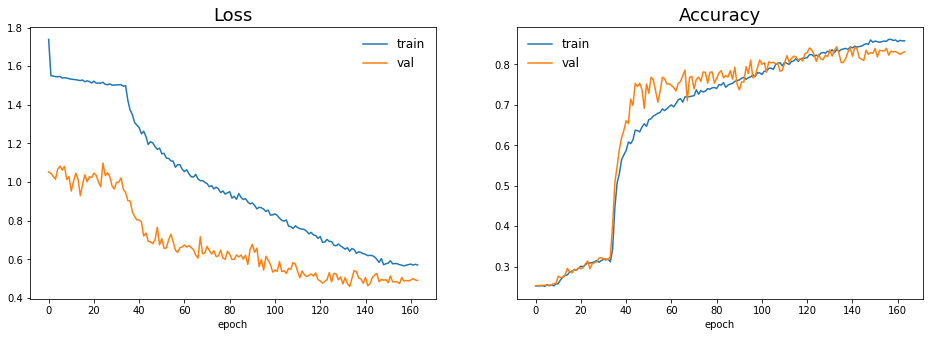

In [23]:
ecg.plot_model_history(fitted_model)

### Metrics

We calculate some metrics to further compare the models. We do all of this using the test set, since that would help us better represent how the models will perform in new data.

In the case of MI prediction, we will look at the results in 3 ways:
    
    1. Using a threshold of 0.5 to determine MI vs Other:
       This one is probably the least important, we only include it since a threshold
       of 0.5 is the most standard way to evaluate  classification problems
       
    2. Equalize recall and specificity:
       This approach has the goal to optimize both recall and specificity as much as possible.
       
    3. Optimize recall:
       We will define a target recall, 90% specifically, and visualize how the other metrics
       behave conditional on this.

In [24]:
# Set the threshold and target recall
threshold      =  0.5
target_recall  =  0.9

if not found:
    # Calculate the metrics given test predictions 
    test_pred, test_score    =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
    test_metrics             =  ecg.calculate_metrics_mi(test_set_y.numpy(), test_pred, test_score,
                                                         target_recall=target_recall)

    # Save the metrics
    with open(result_path + '/metrics.pickle', 'wb') as handle:
        pickle.dump(test_metrics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    num_metrics = {key : values for key, values in test_metrics.items() if ecg.filter_metric(key)}
    pd.Series(num_metrics).to_csv(result_path + '/metrics.csv')

# Retrieve the metrics
with open(result_path + '/metrics.pickle', 'rb') as handle:
    test_metrics = pickle.load(handle)
    
# Obtain  fpr and tpr to plot the ROC curve
fpr, tpr, thresholds = test_metrics['roc_curve']
include_points = {'' : 'orange', 'equal_' : 'green', 'target_' : 'red',}

#### ROC Curve

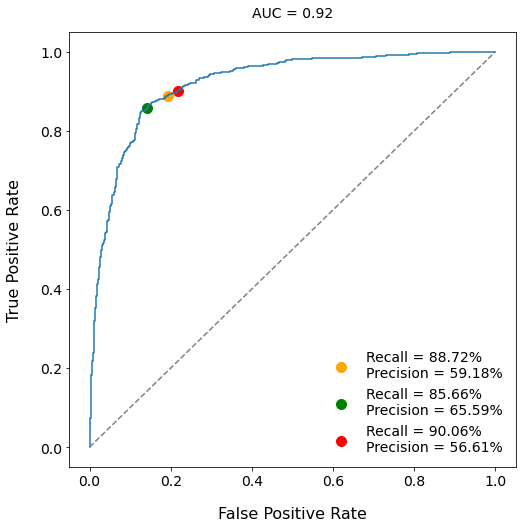

In [25]:
ecg.plot_roc_curve_mi(fpr, tpr, test_metrics, include_points)

**Threshold = 50%**

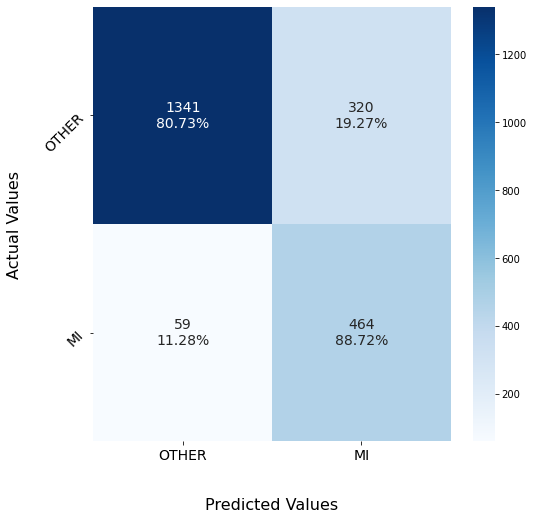

In [26]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['confusion_matrix'])

**Recall = Specificity**

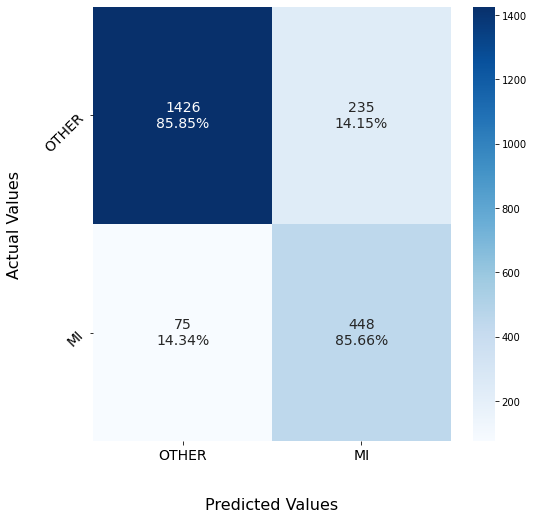

In [27]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['equal_confusion_matrix'])

**Recall = 90%**

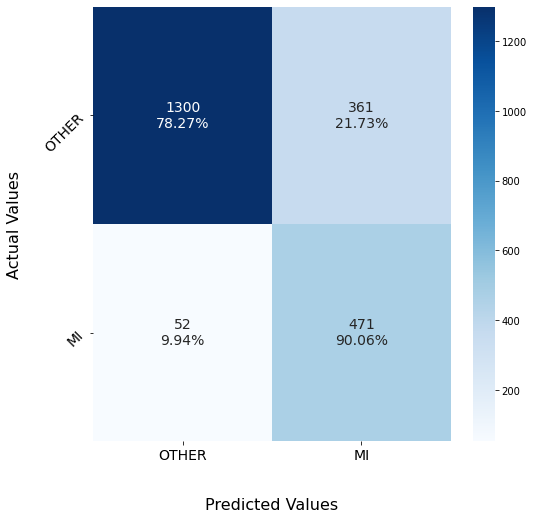

In [28]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['target_confusion_matrix'])

In [29]:
_, test_score       =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
risk_score          =  pd.DataFrame(data=[test_set_y.numpy().reshape(1, -1)[0], test_score.reshape(1, -1)[0]])
risk_score          =  risk_score.transpose()
risk_score.columns  =  ['true', 'pred']

Text(0.5, 0.98, 'Risk Score Distribution')

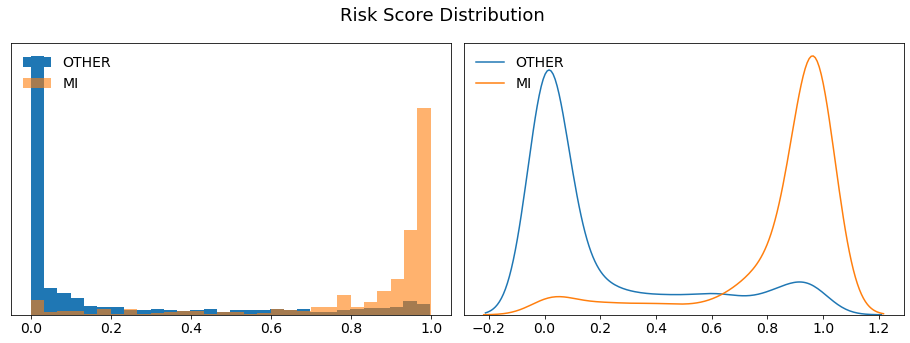

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].hist(risk_score[risk_score['true'] == 0]['pred'], bins=30, density=True, label='OTHER')
axs[0].hist(risk_score[risk_score['true'] == 1]['pred'], bins=30, density=True, alpha=0.6, label='MI')
plt.sca(axs[0]); plt.legend(loc='upper left', fontsize=14, frameon=False)
axs[0].tick_params(labelsize=14)
# axs[0].set_xlabel('Risk Score', fontsize=16)
axs[0].get_yaxis().set_ticks([])


sns.kdeplot(risk_score[risk_score['true'] == 0]['pred'], label='OTHER', ax=axs[1])
sns.kdeplot(risk_score[risk_score['true'] == 1]['pred'], label='MI', ax=axs[1])
plt.sca(axs[1]); plt.legend(loc='upper left', fontsize=14, frameon=False)
axs[1].tick_params(labelsize=14)
# axs[1].set_xlabel('Risk Score', fontsize=16)
axs[1].get_yaxis().set_ticks([])
axs[1].set_ylabel('')
axs[1].set_xlabel('')

fig.subplots_adjust(wspace = 0.03)
plt.suptitle('Risk Score Distribution', fontsize=18, y=0.98)

## Getting the best model (with respect to target and equal metrics)

Having run different combinations for the models, we are now interested in verifying which has the best performance. We will also check if having used a median filtering or removing outliers was beneficial to the model's predictive power.

In [28]:
results = dict()
for idx, path in path_dict.items():
    try:
        
        cutpaths = os.listdir('results/' + path + labels_id + '/')     
        
        for cutpath in cutpaths:
            
            cutpath = 'results/' + path + labels_id + '/' + cutpath + '/'
            subpaths = os.listdir(cutpath)
            
            for subpath in subpaths:

                fullpath = cutpath + subpath + '/'
                path_metrics = pd.read_csv(fullpath + 'metrics.csv', index_col=0)
                model_id = f"{idx}_ct_{fullpath.split('_ct_')[-1].split('/')[0]}_{fullpath.split('/')[-2]}"
                path_metrics.columns = [model_id]
                results[model_id] = path_metrics
                
    except FileNotFoundError:
        pass
    
results = pd.concat([result for result in results.values()], axis=1)
results = results.transpose()

best = results.drop(['recall', 'precision', 'specificity', 'f1', 'accuracy'], axis=1).apply(np.prod, axis=1)
best = best ** (1 / results.shape[1])
best = best.sort_values(ascending=False)

results = 100 * results
results = results.applymap(lambda x : round(x, 2))
best = 100 * best
best = best.apply(lambda x : round(x, 2))
best = pd.DataFrame(best)
best.columns = ['geometric_mean']

These are the top 10 with respect to the geometric mean of all *target* and *equal* metrics.

In [29]:
best.head(10)

,geometric_mean
mf_200_ct_0.5_optim_1,86.41
mf_200_ct_0.8_optim_13,85.10
mf_200_ct_0.5_optim_5,84.85
mf_200_ct_0.8_optim_10,84.85
og_ct_0.5_ks_bn_l1_dr_as_lr_1,84.82
mf_200_ct_0.8_optim_11,84.75
mf_200_ct_0.8_optim_9,84.56
og_ct_0.5_ol_5_25_ks_bn_l1_dr_as_lr_cw_1,84.44
mf_200_ct_0.8_optim_8,84.32
mf_200_ct_0.8_optim_14,84.19


Here is a complete graph of all the models and their geometric mean metric.

Text(0.5, 0, '($\\pi)$')

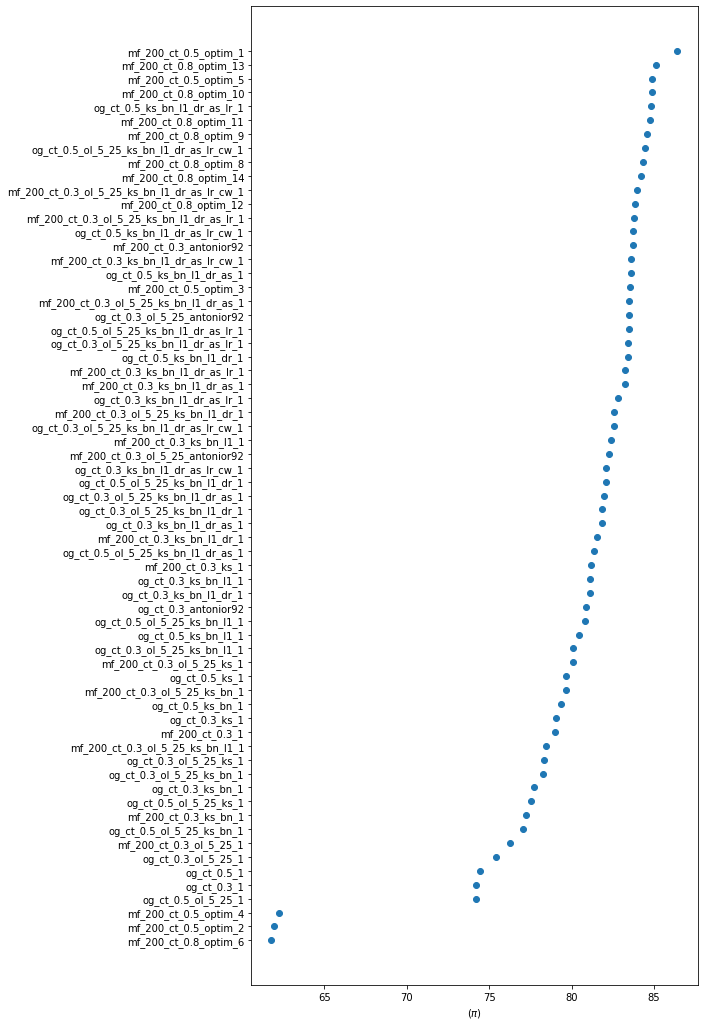

In [30]:
fig, ax = plt.subplots(figsize=(8, 18))
aux = best.sort_values(by='geometric_mean', ascending=True)
ax.scatter(aux['geometric_mean'], aux.index)
ax.set_xlabel('('r'$\pi)$')

FFor purposes of showing it in a report, we select only some examples

Text(0.5, 1.03, 'Model performance comparison\ngiven $\\pi$ metric')

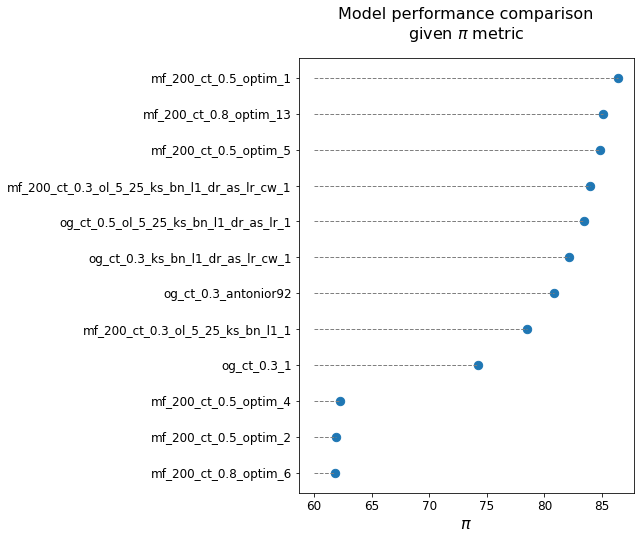

In [37]:
fig, ax = plt.subplots(figsize=(6, 8))

aux = best.copy()
aux = pd.concat([aux.head(3),                  
                 best.iloc[10:11, :],
                 best.iloc[20:21, :],
                 best.iloc[30:31, :],
                 best.iloc[40:41, :],
                 best.iloc[50:51, :],
                 best.iloc[60:61, :],
                 aux.tail(3)])
aux = aux.sort_values(by='geometric_mean', ascending=True)

ax.scatter(aux['geometric_mean'], aux.index, s=70)
for v, idx in zip(aux['geometric_mean'], aux.index):
    ax.plot([60, v], [idx, idx], color='gray', ls='--', lw=1)
ax.set_xlabel(''r'$\pi$', fontsize=16)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_title('Model performance comparison\ngiven 'r'$\pi$ metric', fontsize=16, y=1.03)

We retrieve the best model. 

**Note:** It would be best to automate this.

In [38]:
best_model_ = '/PTB-XL_mf=200/mi/mf_200_ct_0.5/optim_1'

In [39]:
test_x = (test_set_x, test_set_age_n_sex)

In [40]:
best_model_model_path = 'models' + best_model_
best_model_results_path = 'results' + best_model_

In [41]:
model = tf.keras.models.load_model(best_model_model_path + '/model.h5')
fitted_model = pd.read_csv(best_model_results_path + '/history.csv', index_col=0)

In [43]:
print('Number of parameters:')    
ecg.get_number_of_parameters(model, path = best_model_model_path)  

Number of parameters:
Total params:  2,918,303
Trainable params:  2,918,303
Non-trainable params:  0


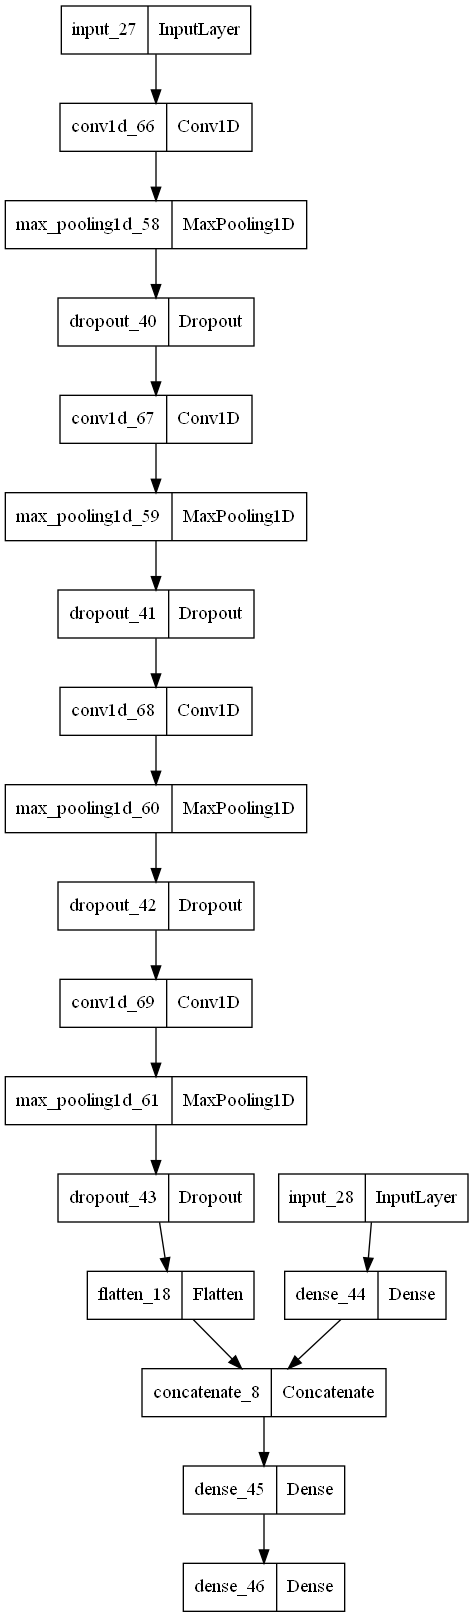

In [44]:
tf.keras.utils.plot_model(model)

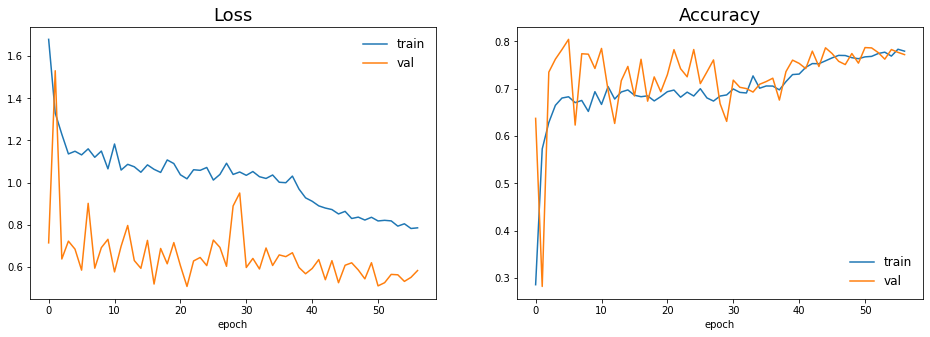

In [45]:
ecg.plot_model_history(fitted_model)

In [46]:
# Retrieve the metrics
with open(best_model_results_path + '/metrics.pickle', 'rb') as handle:
    test_metrics = pickle.load(handle)
    
# Obtain  fpr and tpr to plot the ROC curve
fpr, tpr, thresholds = test_metrics['roc_curve']
include_points = {'' : 'orange', 'equal_' : 'green', 'target_' : 'red',}

#### ROC Curve

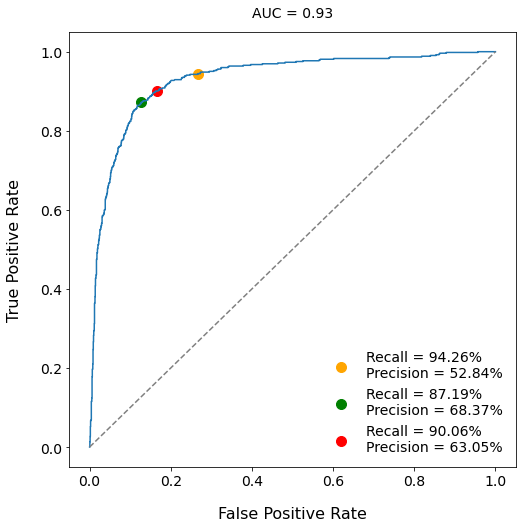

In [47]:
ecg.plot_roc_curve_mi(fpr, tpr, test_metrics, include_points)

**Threshold = 50%**

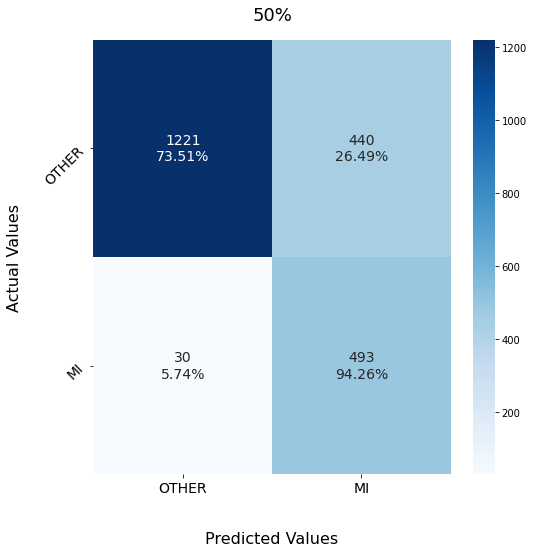

In [89]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['confusion_matrix'], title='50%')

**Recall = Specificity**

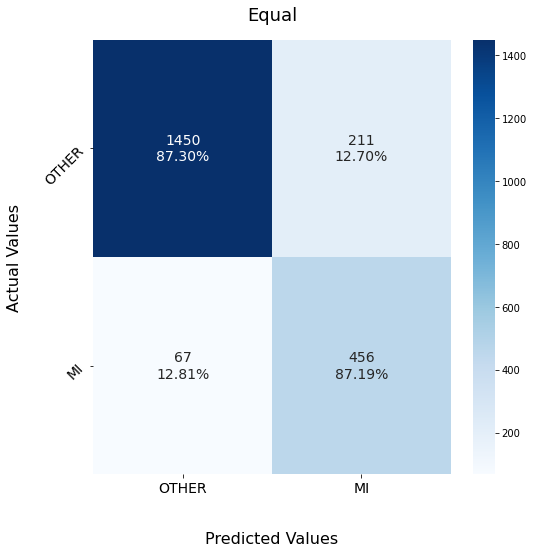

In [90]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['equal_confusion_matrix'], title='Equal')

**Recall = 90%**

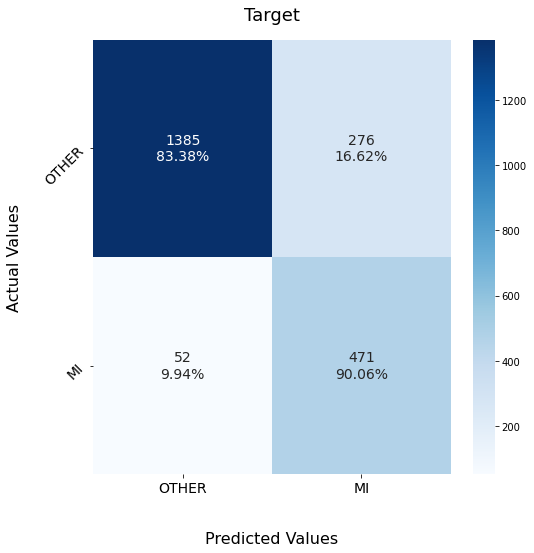

In [91]:
ecg.plot_confusion_matrix_mi(cm=test_metrics['target_confusion_matrix'], title='Target')

In [51]:
threshold = 0.5
_, test_score       =  ecg.predict_mi(x=test_x, model=model, threshold=threshold)
risk_score          =  pd.DataFrame(data=[test_set_y.numpy().reshape(1, -1)[0], test_score.reshape(1, -1)[0]])
risk_score          =  risk_score.transpose()
risk_score.columns  =  ['true', 'pred']
risk_score.index = test_set_idx

Text(0.5, 0.98, 'Risk Score Distribution')

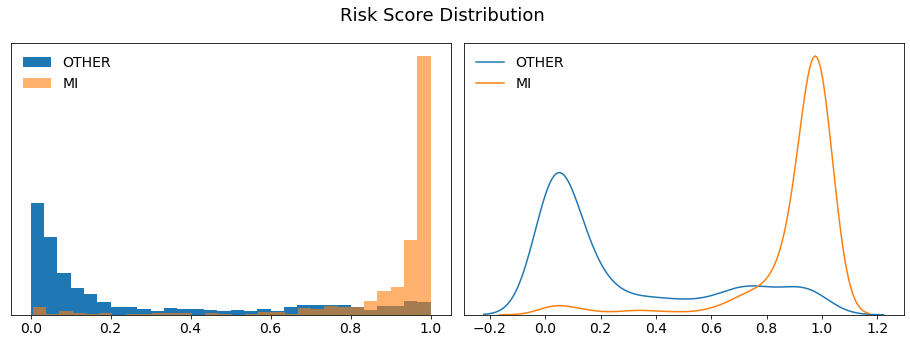

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].hist(risk_score[risk_score['true'] == 0]['pred'], bins=30, density=True, label='OTHER')
axs[0].hist(risk_score[risk_score['true'] == 1]['pred'], bins=30, density=True, alpha=0.6, label='MI')
plt.sca(axs[0]); plt.legend(loc='upper left', fontsize=14, frameon=False)
axs[0].tick_params(labelsize=14)
# axs[0].set_xlabel('Risk Score', fontsize=16)
axs[0].get_yaxis().set_ticks([])


sns.kdeplot(risk_score[risk_score['true'] == 0]['pred'], label='OTHER', ax=axs[1])
sns.kdeplot(risk_score[risk_score['true'] == 1]['pred'], label='MI', ax=axs[1])
plt.sca(axs[1]); plt.legend(loc='upper left', fontsize=14, frameon=False)
axs[1].tick_params(labelsize=14)
# axs[1].set_xlabel('Risk Score', fontsize=16)
axs[1].get_yaxis().set_ticks([])
axs[1].set_ylabel('')
axs[1].set_xlabel('')

fig.subplots_adjust(wspace = 0.03)
plt.suptitle('Risk Score Distribution', fontsize=18, y=0.98)

Text(0.5, 0.98, 'Risk Score Distribution')

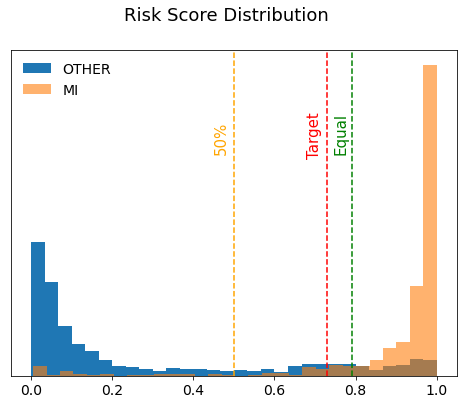

In [76]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(risk_score[risk_score['true'] == 0]['pred'], bins=30, density=True, label='OTHER')
ax.hist(risk_score[risk_score['true'] == 1]['pred'], bins=30, density=True, alpha=0.6, label='MI')
plt.sca(ax); plt.legend(loc='upper left', fontsize=14, frameon=False)
ax.tick_params(labelsize=14)
# ax.set_xlabel('Risk Score', fontsize=16)
ax.get_yaxis().set_ticks([])

ax.axvline(0.5, color='orange', ls='--')
ax.axvline(test_metrics['equal_threshold'], color='green', ls='--')
ax.axvline(test_metrics['target_threshold'], color='red', ls='--')

ax.text(0.5-0.05, 12, '50%', color='orange', rotation=90, size=15)
ax.text(test_metrics['equal_threshold']-0.045, 12, 'Equal', color='green', rotation=90, size=15)
ax.text(test_metrics['target_threshold']-0.05, 11.8, 'Target', color='red', rotation=90, size=15)

test_metrics['equal_threshold']

fig.subplots_adjust(wspace = 0.03)
plt.suptitle('Risk Score Distribution', fontsize=18, y=0.98)